# Notebook: Vergleichende Analyse von Demographie und Rechtswahl (AfD/SVP) in Konstanz und Kreuzlingen

Dieses Notebook analysiert und vergleicht demographische Strukturen und Rechtswahl (AfD/SVP) in Konstanz, Landkreis Konstanz und Kreuzlingen. Es umfasst Datenüberblick, Preprocessing, Visualisierung, statistische Analyse und ein einfaches Vorhersagemodell.

## 1. Import und Setup

Importiere alle benötigten Bibliotheken und setze globale Einstellungen für Visualisierung und Pfade.

In [71]:
%pip install geopandas
!pip install "folium>=0.12" matplotlib mapclassify


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import os
import re

# Visualisierungseinstellungen
sns.set(style="whitegrid", palette="tab10", font_scale=1.1)
plt.rcParams["figure.figsize"] = (12, 6)

# Datenpfade
data_dir = "/Users/tessabartels/Desktop/Coding/Datenjournalismus/data"
output_dir = "/Users/tessabartels/Desktop/Coding/Datenjournalismus/data/output_preprocessing"

## 2. Datenüberblick und Preprocessing

Lese die relevanten Datensätze für Konstanz, Landkreis Konstanz und Kreuzlingen ein. Führe grundlegende Bereinigungen, Typkonvertierungen und Aggregationen durch. Zeige einen Überblick über die wichtigsten Variablen und deren Verteilung.

In [73]:
# Konstanz: Demographie und Wahldaten
df_kn = pd.read_csv(f"{output_dir}/df_kn_wahlergebnis_demo.csv")
# Landkreis Konstanz: Demographie und Wahldaten
df_lk_kn = pd.read_csv(f"{output_dir}/df_lk_kn_gesamt_wahl.csv")
# Kreuzlingen: Demographie und Wahldaten
df_kr = pd.read_csv(f"{output_dir}/df_kreuzlingen_demographie_parteistaerke.csv")

# Übersicht: Spalten und erste Zeilen
print("Konstanz:", df_kn.columns.tolist())
print(df_kn.head(2))
print("Landkreis KN:", df_lk_kn.columns.tolist())
print(df_lk_kn.head(2))
print("Kreuzlingen:", df_kr.columns.tolist())
print(df_kr.head(2))

# Grundlegende Typkonvertierungen (Beispiel für Konstanz)
for col in ['einw_hw_gesamt', 'einw_hw_frauen', 'einw_hw_deutsch', 'einw_hw_nichtdeutsch']:
    if col in df_kn.columns:
        df_kn[col] = pd.to_numeric(df_kn[col], errors='coerce')

# Überblick: Verteilung wichtiger Variablen
df_kn.describe(include='all').T

Konstanz: ['wahljahr', 'demo_jahr', 'stadtteil', 'gemeinde', 'stt', 'stadtviertel', 'einw_hw_gesamt', 'einw_hw_frauen', 'einw_hw_deutsch', 'einw_hw_nichtdeutsch', 'einw_hw_unter18', 'einw_hw_18_bis_unter_30', 'einw_hw_30_bis_unter_40', 'einw_hw_40_bis_unter_50', 'einw_hw_50_bis_unter_60', 'einw_hw_60_und_aelter', 'haushalte', 'arbeitslose', 'sozialversicherungspflichtig_beschaeftigte', 'HH_insgesamt', 'HH_1-Person', 'HH_2-Personen', 'HH_3+-Personen', 'religion_katholisch', 'religion_evangelisch', 'religion_sonstige', 'AfD', 'BIG', 'BSW', 'Buendnis C', 'Buendnis Deutschland', 'BüSo', 'CDU', 'DIE LINKE', 'Die Linke', 'Die Partei', 'FDP', 'FREIE WAEHLER', 'FREIE WÄHLER', 'GRUENE', 'GRÜNE', 'LINKE', 'MLPD', 'NPD', 'OEDP', 'PARTEI DER VERNUNFT', 'PBC', 'Piraten', 'RENTNER', 'REP', 'SPD', 'Sonstige', 'Tierschutzpartei', 'Volksabstimmung', 'Volt', 'Wahlbeteiligung', 'die Basis', 'pro Deutschland', 'sonstige', 'ÖDP']
   wahljahr  demo_jahr       stadtteil  gemeinde  stt  stadtviertel  \
0     

count unique             top freq  \
wahljahr                                    64.0    NaN             NaN  NaN   
demo_jahr                                   64.0    NaN             NaN  NaN   
stadtteil                                     64     16  Stadt Konstanz    4   
gemeinde                                      64      1        Konstanz   64   
stt                                         64.0    NaN             NaN  NaN   
stadtviertel                                64.0    NaN             NaN  NaN   
einw_hw_gesamt                              64.0    NaN             NaN  NaN   
einw_hw_frauen                              64.0    NaN             NaN  NaN   
einw_hw_deutsch                             64.0    NaN             NaN  NaN   
einw_hw_nichtdeutsch                        64.0    NaN             NaN  NaN   
einw_hw_unter18                             64.0    NaN             NaN  NaN   
einw_hw_18_bis_unter_30                     64.0    NaN             NaN  NaN   
einw_hw_30_bis_unter_40                     64.0    NaN             NaN  NaN   
einw_hw_40_bis_unter_50                     64.0    NaN             NaN  NaN   
einw_hw_50_bis_unter_60                     64.0    NaN             NaN  NaN   
einw_hw_60_und_aelter                       64.0    NaN             NaN  NaN   
haushalte                                   64.0    NaN             NaN  NaN   
arbeitslose                                 60.0    NaN             NaN  NaN   
sozialversicherungspflichtig_beschaeftigte  60.0    NaN             NaN  NaN   
HH_insgesamt                                52.0    NaN             NaN  NaN   
HH_1-Person                                 52.0    NaN             NaN  NaN   
HH_2-Personen                               52.0    NaN             NaN  NaN   
HH_3+-Personen                              52.0    NaN             NaN  NaN   
religion_katholisch                         60.0    NaN             NaN  NaN   
religion_evangelisch                        60.0    NaN             NaN  NaN   
religion_sonstige                           60.0    NaN             NaN  NaN   
AfD                                         64.0    NaN             NaN  NaN   
BIG                                         16.0    NaN             NaN  NaN   
BSW                                         16.0    NaN             NaN  NaN   
Buendnis C                                  16.0    NaN             NaN  NaN   
Buendnis Deutschland                        16.0    NaN             NaN  NaN   
BüSo                                        16.0    NaN             NaN  NaN   
CDU                                         64.0    NaN             NaN  NaN   
DIE LINKE                                   16.0    NaN             NaN  NaN   
Die Linke                                   32.0    NaN             NaN  NaN   
Die Partei                                  16.0    NaN             NaN  NaN   
FDP                                         64.0    NaN             NaN  NaN   
FREIE WAEHLER                               16.0    NaN             NaN  NaN   
FREIE WÄHLER                                16.0    NaN             NaN  NaN   
GRUENE                                      32.0    NaN             NaN  NaN   
GRÜNE                                       32.0    NaN             NaN  NaN   
LINKE                                       16.0    NaN             NaN  NaN   
MLPD                                        32.0    NaN             NaN  NaN   
NPD                                         16.0    NaN             NaN  NaN   
OEDP                                        16.0    NaN             NaN  NaN   
PARTEI DER VERNUNFT                         16.0    NaN             NaN  NaN   
PBC                                         16.0    NaN             NaN  NaN   
Piraten                                     16.0    NaN             NaN  NaN   
RENTNER                                     16.0    NaN             NaN  NaN   
REP                                        

## 3. Durchschnittsbürger*in: Demographische Profile vergleichen

Berechne und vergleiche die durchschnittlichen demographischen Profile (Alter, Geschlecht, Nationalität, Haushaltsgröße, Bildung) für Konstanz, Landkreis Konstanz und Kreuzlingen. Stelle die Ergebnisse tabellarisch dar.

In [74]:
profile_cols = {
    "Alter (Ø)": lambda df: np.average(
        [20, 35, 45, 55, 65, 75, 85],
        weights=[df.get(col, pd.Series([0])).sum() for col in [
            'einw_hw_18_bis_unter_30', 'einw_hw_30_bis_unter_40', 'einw_hw_40_bis_unter_50',
            'einw_hw_50_bis_unter_60', 'einw_hw_60_und_aelter', 'einw_hw_unter18', 'einw_hw_30_bis_unter_40'
        ]]
    ) if 'einw_hw_18_bis_unter_30' in df.columns and df.get('einw_hw_gesamt', pd.Series([0])).sum() > 0 else np.nan,
    "Frauen-Anteil (%)": lambda df: (
        100 * df.get('einw_hw_frauen', pd.Series([0])).sum() / df.get('einw_hw_gesamt', pd.Series([0])).sum()
        if df.get('einw_hw_gesamt', pd.Series([0])).sum() > 0 else np.nan
    ),
    "Deutsche/Schweizer (%)": lambda df: (
        100 * df.get('einw_hw_deutsch', pd.Series([0])).sum() / df.get('einw_hw_gesamt', pd.Series([0])).sum()
        if 'einw_hw_deutsch' in df.columns and df.get('einw_hw_gesamt', pd.Series([0])).sum() > 0 else np.nan
    ),
    "Haushaltsgröße (Ø)": lambda df: (
        df.get('einw_hw_gesamt', pd.Series([0])).sum() / df.get('haushalte', pd.Series([0])).sum()
        if 'haushalte' in df.columns and df.get('haushalte', pd.Series([0])).sum() > 0 else np.nan
    ),
}

def get_profile(df, name):
    return {
        "Region": name,
        **{k: round(f(df), 2) for k, f in profile_cols.items()}
    }

profiles = [
    get_profile(df_kn, "Konstanz"),
    get_profile(df_lk_kn, "Landkreis Konstanz"),
    get_profile(df_kr, "Kreuzlingen"),
]
df_profiles = pd.DataFrame(profiles)
df_profiles

Region  Alter (Ø)  Frauen-Anteil (%)  Deutsche/Schweizer (%)  \
0            Konstanz      52.56              52.12                   84.42   
1  Landkreis Konstanz        NaN                NaN                     NaN   
2         Kreuzlingen        NaN                NaN                     NaN   

   Haushaltsgröße (Ø)  
0                1.76  
1                 NaN  
2                 NaN

In [75]:
# Durchschnittsbürger für Kreuzlingen berechnen

profile_kr = {
    "Region": "Kreuzlingen",
    "Alter (Ø)": np.average(
        [9, 24, 34, 44, 54, 64, 74, 85],  # Mittelwerte der Altersgruppen
        weights=[
            df_kr['0-17'].sum(),
            df_kr['18-29'].sum(),
            df_kr['30-39'].sum(),
            df_kr['40-49'].sum(),
            df_kr['50-59'].sum(),
            df_kr['60-69'].sum(),
            df_kr['70-79'].sum(),
            df_kr['80+'].sum()
        ]
    ) if all(col in df_kr.columns for col in ['0-17','18-29','30-39','40-49','50-59','60-69','70-79','80+']) else np.nan,
    "Frauen-Anteil (%)": (
        100 * (df_kr['Weiblich_Schweiz'].sum() + df_kr['Weiblich_Ausland'].sum()) / df_kr['gesamtbevölkerung'].sum()
        if all(col in df_kr.columns for col in ['Weiblich_Schweiz','Weiblich_Ausland','gesamtbevölkerung']) else np.nan
    ),
    "Schweizer Anteil (%)": (
        100 * (df_kr['Männlich_Schweiz'].sum() + df_kr['Weiblich_Schweiz'].sum()) / df_kr['gesamtbevölkerung'].sum()
        if all(col in df_kr.columns for col in ['Männlich_Schweiz','Weiblich_Schweiz','gesamtbevölkerung']) else np.nan
    ),
    "Haushaltsgröße (Ø)": np.nan  # Keine Haushaltsdaten in df_kr vorhanden
}

print("Durchschnittsbürger Kreuzlingen:")
for k, v in profile_kr.items():
    print(f"{k}: {v}")

Durchschnittsbürger Kreuzlingen:
Region: Kreuzlingen
Alter (Ø): 42.52780475217134
Frauen-Anteil (%): 49.83600323240006
Schweizer Anteil (%): 59.282624491542116
Haushaltsgröße (Ø): nan


## 4. Visualisierung: Karten und regionale Verteilung

Erstelle Karten zur Visualisierung der regionalen Verteilung von demographischen Merkmalen und Rechtswahl-Anteilen auf Stadtteil-/Gemeindeebene.

In [76]:
# Annahme: Shapefile für Konstanz-Stadtteile liegt vor
shp_path_kn = f"{data_dir}/Konstanz/konstanz_stadtteile.shp"
if os.path.exists(shp_path_kn):
    gdf_kn = gpd.read_file(shp_path_kn)
    # Merge mit Daten
    gdf_kn = gdf_kn.merge(df_kn[df_kn['wahljahr'] == df_kn['wahljahr'].max()], left_on='stadtteil', right_on='stadtteil', how='left')
    gdf_kn.plot(column='AfD', cmap='Reds', legend=True, edgecolor='black')
    plt.title("AfD-Anteil nach Stadtteil (Konstanz, letztes Wahljahr)")
    plt.axis('off')
    plt.show()
else:
    print("Shapefile für Konstanz-Stadtteile nicht gefunden. Kartenvisualisierung übersprungen.")

Shapefile für Konstanz-Stadtteile nicht gefunden. Kartenvisualisierung übersprungen.


## 5. Analyse: Wer wählt rechts? (AfD/SVP)

Analysiere die Wahlergebnisse für AfD (Deutschland) und SVP (Schweiz) auf Stadtteil-/Gemeindeebene. Identifiziere Regionen mit besonders hohen oder niedrigen Rechtswahl-Anteilen und stelle diese grafisch dar.

Top AfD-Stadtteile Konstanz:
           stadtteil   AfD
58  Industriegebiet  19.1
57     Wollmatingen  15.0
56     Fuerstenberg  13.9
62        Dettingen  12.3
63       Wallhausen  12.1
Flop AfD-Stadtteile Konstanz:
            stadtteil  AfD
54      Allmannsdorf  7.2
49          Altstadt  8.0
50          Paradies  8.2
55             Staad  8.2
52  Petershausen-Ost  8.7
Top SVP-Gemeinden Kreuzlingen:
      GEMEINDE_NAME   SVP
38     Raperswilen  58.5
41           Wäldi  57.8
35  Langrickenbach  54.9
33       Kemmental  48.5
32       Güttingen  42.3
Flop SVP-Gemeinden Kreuzlingen:
     GEMEINDE_NAME   SVP
34    Kreuzlingen  26.6
31     Gottlieben  29.4
29    Bottighofen  29.7
40     Tägerwilen  32.0
37  Münsterlingen  34.6


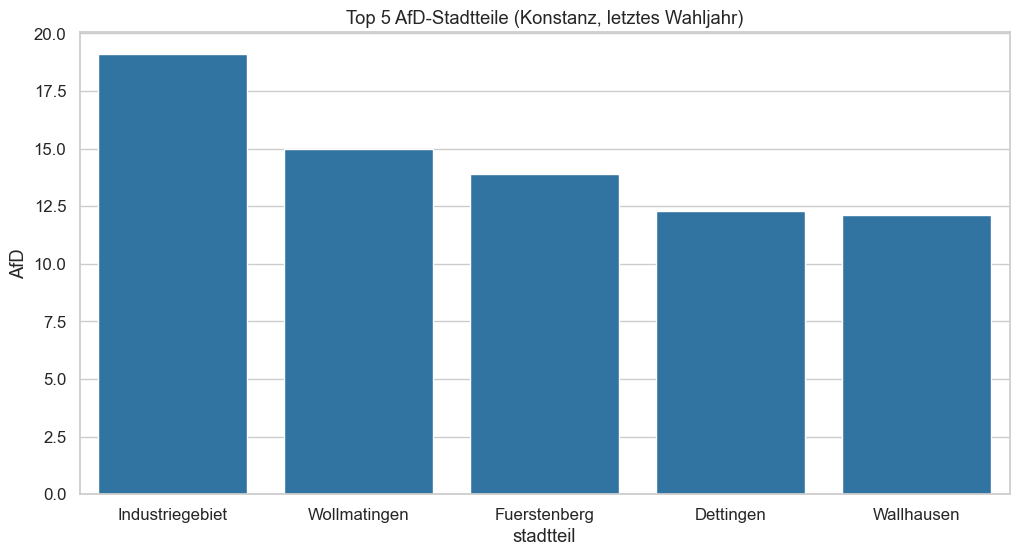

In [77]:
# Top- und Flop-Regionen nach Rechtswahl-Anteil
def top_flop_regions(df, partei, region_col, n=5):
    if partei in df.columns:
        top = df.sort_values(partei, ascending=False).head(n)[[region_col, partei]]
        flop = df.sort_values(partei, ascending=True).head(n)[[region_col, partei]]
        return top, flop
    return None, None

top_kn, flop_kn = top_flop_regions(df_kn[df_kn['wahljahr'] == df_kn['wahljahr'].max()], 'AfD', 'stadtteil')
top_kr, flop_kr = top_flop_regions(df_kr[df_kr['WAHLJAHR'] == df_kr['WAHLJAHR'].max()], 'SVP', 'GEMEINDE_NAME')

print("Top AfD-Stadtteile Konstanz:\n", top_kn)
print("Flop AfD-Stadtteile Konstanz:\n", flop_kn)
print("Top SVP-Gemeinden Kreuzlingen:\n", top_kr)
print("Flop SVP-Gemeinden Kreuzlingen:\n", flop_kr)

# Visualisierung
sns.barplot(data=top_kn, x='stadtteil', y='AfD')
plt.title("Top 5 AfD-Stadtteile (Konstanz, letztes Wahljahr)")
plt.show()

/var/folders/xb/3cn73kh15fx078zh0ryb_lrc0000gn/T/ipykernel_9333/1658717442.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


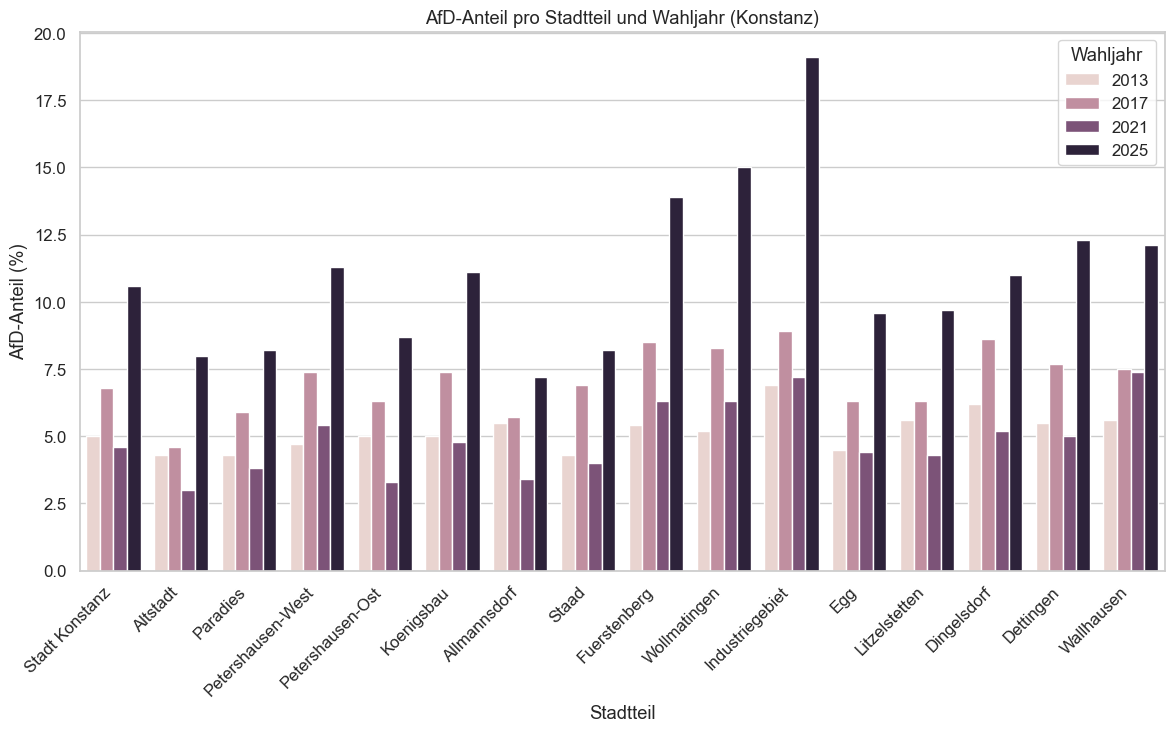

In [78]:
# Balkendiagramm: AfD-Anteil pro Stadtteil für alle Wahljahre

import matplotlib.pyplot as plt
import seaborn as sns

if all(col in df_kn.columns for col in ['stadtteil', 'wahljahr', 'AfD']):
    plt.figure(figsize=(14, 7))
    sns.barplot(
        data=df_kn,
        x='stadtteil',
        y='AfD',
        hue='wahljahr',
        ci=None
    )
    plt.title("AfD-Anteil pro Stadtteil und Wahljahr (Konstanz)")
    plt.ylabel("AfD-Anteil (%)")
    plt.xlabel("Stadtteil")
    plt.xticks(rotation=45, ha='right')
    plt.legend(title="Wahljahr")

/var/folders/xb/3cn73kh15fx078zh0ryb_lrc0000gn/T/ipykernel_9333/2044555210.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


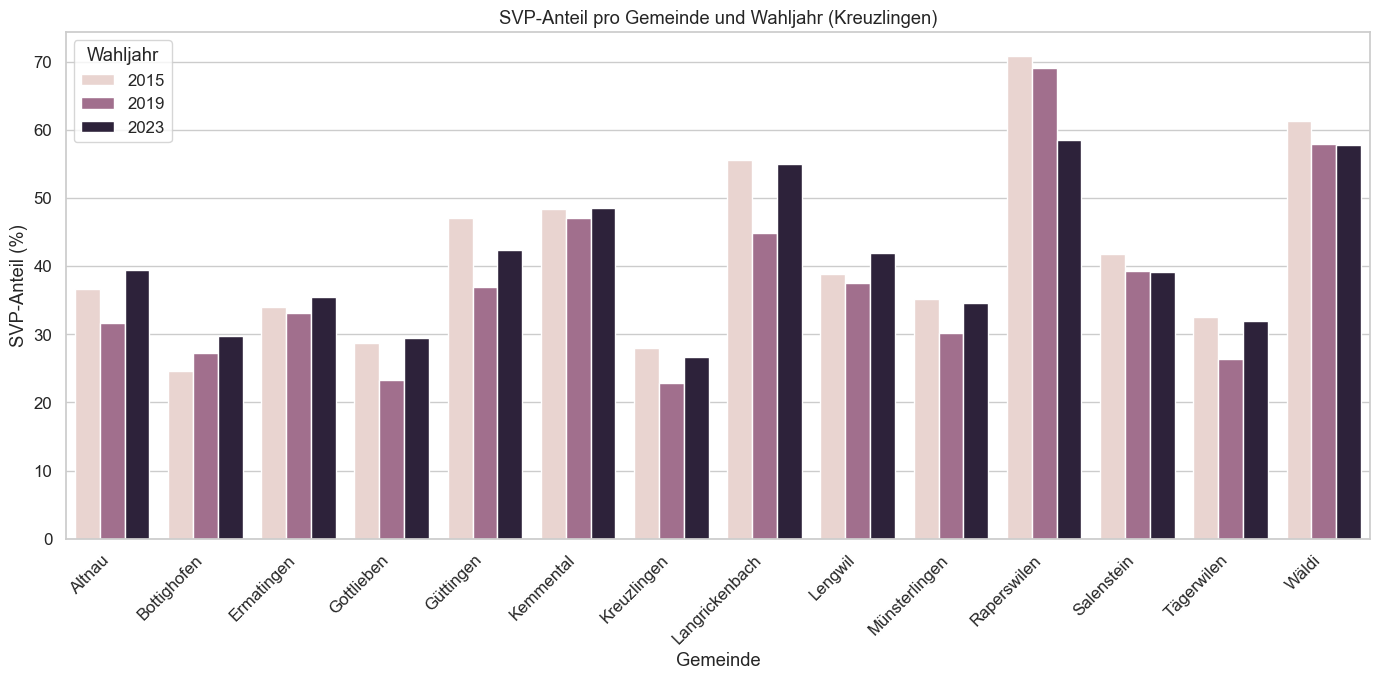

In [79]:
# Balkendiagramm: SVP-Anteil pro Gemeinde für alle Wahljahre (Kreuzlingen)

import matplotlib.pyplot as plt
import seaborn as sns

if all(col in df_kr.columns for col in ['GEMEINDE_NAME', 'WAHLJAHR', 'SVP']):
    plt.figure(figsize=(14, 7))
    sns.barplot(
        data=df_kr,
        x='GEMEINDE_NAME',
        y='SVP',
        hue='WAHLJAHR',
        ci=None
    )
    plt.title("SVP-Anteil pro Gemeinde und Wahljahr (Kreuzlingen)")
    plt.ylabel("SVP-Anteil (%)")
    plt.xlabel("Gemeinde")
    plt.xticks(rotation=45, ha='right')
    plt.legend(title="Wahljahr")
    plt.tight_layout()
    plt.show()
else:
    print("Benötigte Spalten nicht vorhanden.")

## 6. Statistische Zusammenhänge: Demographie vs. Rechtswahl

Berechne Korrelationen und führe einfache Regressionsanalysen durch, um Zusammenhänge zwischen demographischen Merkmalen (z.B. Altersgruppen, Geschlecht, Nationalität, Arbeitslosigkeit) und Rechtswahl-Anteilen zu untersuchen.

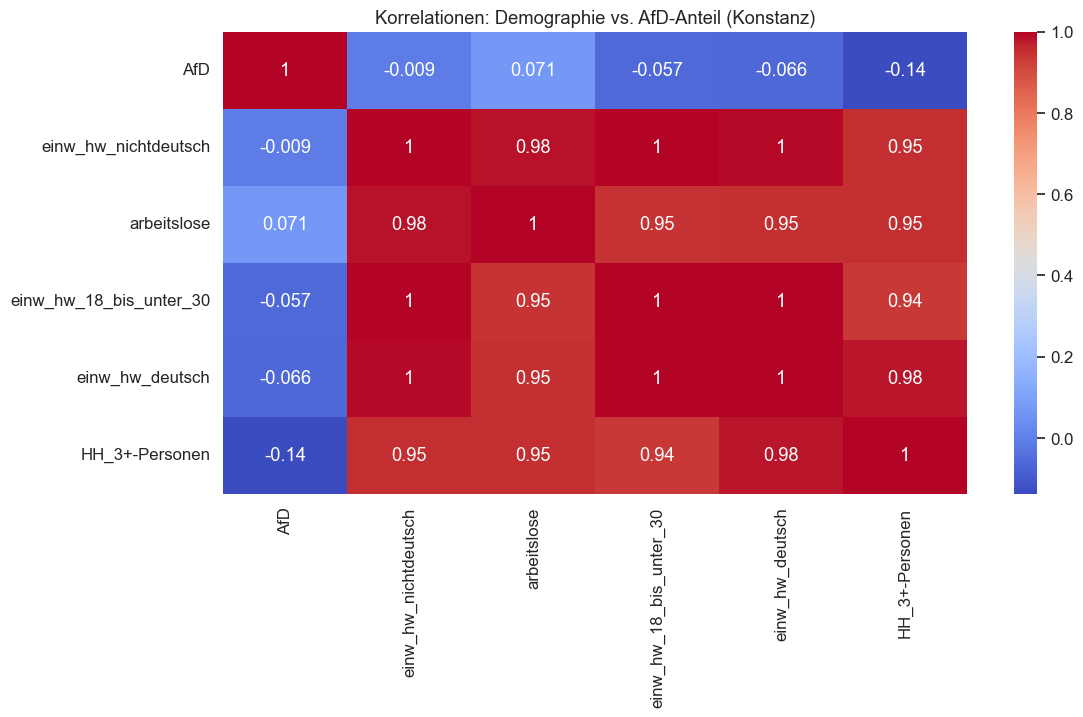

Regression: AfD-Anteil ~ Nichtdeutsche + Arbeitslose
Koeffizienten: [-8.51757228e-06  1.99695326e-03]
R2: 0.006078823460868632


In [80]:
# Beispiel: Korrelationen für Konstanz (letztes Wahljahr)
corr_cols = ['AfD', 'einw_hw_nichtdeutsch', 'arbeitslose', 'einw_hw_18_bis_unter_30', 'einw_hw_deutsch', 'HH_3+-Personen']
df_corr = df_kn[df_kn['wahljahr'] == df_kn['wahljahr'].max()][corr_cols].corr()
sns.heatmap(df_corr, annot=True, cmap='coolwarm')
plt.title("Korrelationen: Demographie vs. AfD-Anteil (Konstanz)")
plt.show()

# Einfache Regression: AfD-Anteil ~ Anteil Nichtdeutsche + Arbeitslose
X = df_kn[df_kn['wahljahr'] == df_kn['wahljahr'].max()][['einw_hw_nichtdeutsch', 'arbeitslose']].fillna(0)
y = df_kn[df_kn['wahljahr'] == df_kn['wahljahr'].max()]['AfD'].fillna(0)
model = LinearRegression().fit(X, y)
print("Regression: AfD-Anteil ~ Nichtdeutsche + Arbeitslose")
print("Koeffizienten:", model.coef_)
print("R2:", model.score(X, y))

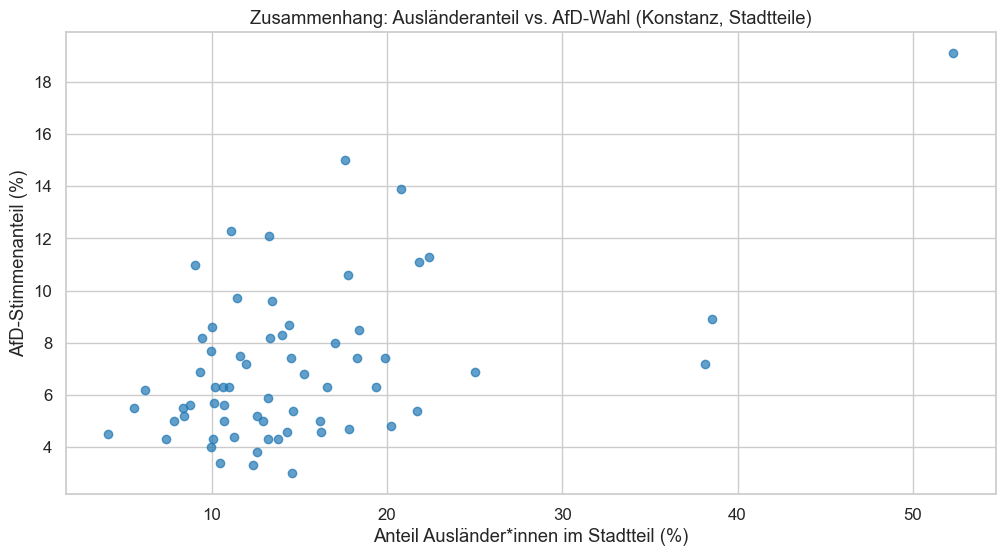

Korrelation Ausländeranteil vs. AfD-Stimmenanteil: 0.505


In [ ]:
G

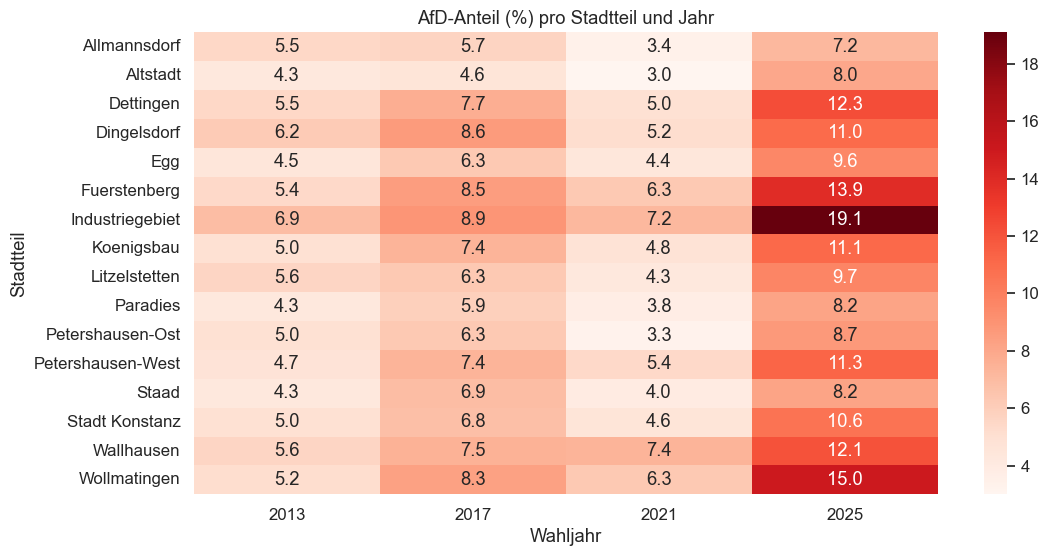

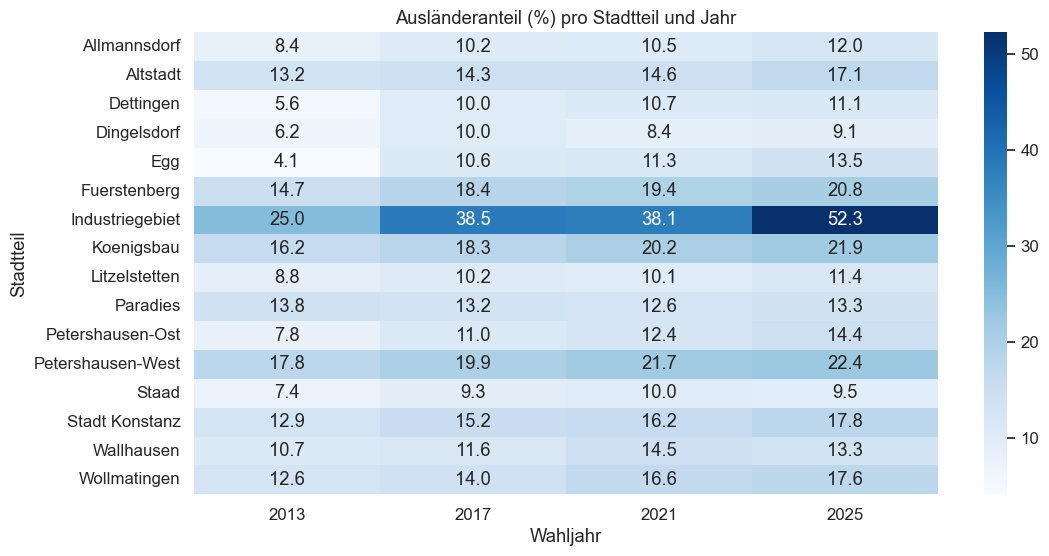

In [82]:
# Anteil Ausländer*innen pro Stadtteil und Jahr berechnen
df_kn['anteil_auslaender'] = 100 * df_kn['einw_hw_nichtdeutsch'] / df_kn['einw_hw_gesamt']

# Pivot-Tabelle: Zeilen=Stadtteil, Spalten=Jahr, Werte=AfD-Anteil
afd_pivot = df_kn.pivot_table(index='stadtteil', columns='wahljahr', values='AfD')
ausl_pivot = df_kn.pivot_table(index='stadtteil', columns='wahljahr', values='anteil_auslaender')

# Heatmap: AfD-Anteil pro Stadtteil und Jahr
plt.figure(figsize=(12, 6))
sns.heatmap(afd_pivot, annot=True, fmt=".1f", cmap="Reds")
plt.title("AfD-Anteil (%) pro Stadtteil und Jahr")
plt.ylabel("Stadtteil")
plt.xlabel("Wahljahr")
plt.show()

# Heatmap: Ausländeranteil pro Stadtteil und Jahr
plt.figure(figsize=(12, 6))
sns.heatmap(ausl_pivot, annot=True, fmt=".1f", cmap="Blues")
plt.title("Ausländeranteil (%) pro Stadtteil und Jahr")
plt.ylabel("Stadtteil")
plt.xlabel("Wahljahr")
plt.show()




## 7. Fokus: Junge Männer und Rechtswahl

Untersuche speziell den Zusammenhang zwischen dem Anteil junger Männer (z.B. 18-29 Jahre) und den Rechtswahl-Anteilen in den Regionen. Visualisiere die Ergebnisse mit Scatterplots und berechne Korrelationen.

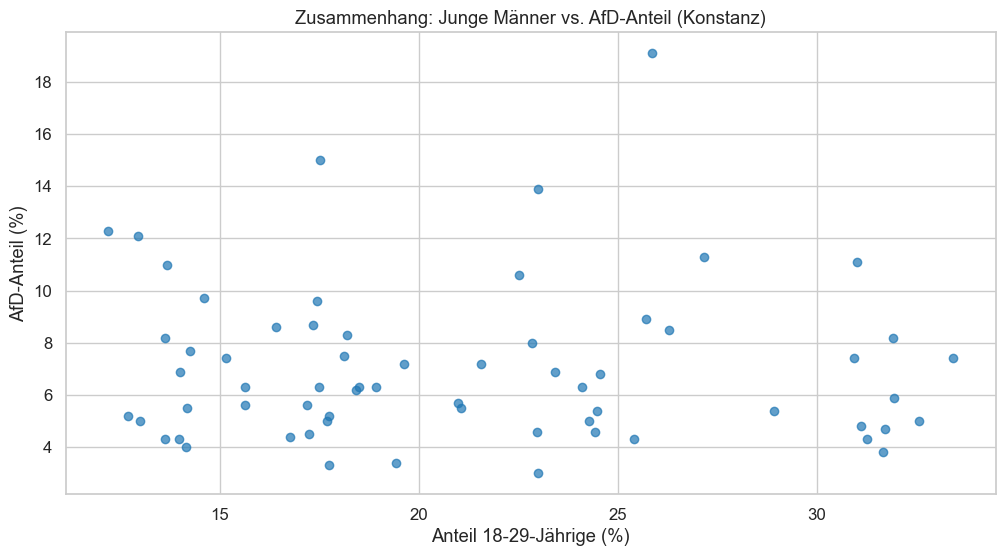

Korrelation Anteil junge Männer vs. AfD: -0.041


In [83]:
# Anteil junger Männer (18-29) schätzen (wenn Daten vorhanden)
if 'einw_hw_18_bis_unter_30' in df_kn.columns and 'einw_hw_gesamt' in df_kn.columns:
    df_kn['anteil_junge_maenner'] = df_kn['einw_hw_18_bis_unter_30'] / df_kn['einw_hw_gesamt'] * 100
    plt.scatter(df_kn['anteil_junge_maenner'], df_kn['AfD'], alpha=0.7)
    plt.xlabel("Anteil 18-29-Jährige (%)")
    plt.ylabel("AfD-Anteil (%)")
    plt.title("Zusammenhang: Junge Männer vs. AfD-Anteil (Konstanz)")
    plt.show()
    corr = df_kn[['anteil_junge_maenner', 'AfD']].corr().iloc[0,1]
    print("Korrelation Anteil junge Männer vs. AfD:", round(corr, 3))
else:
    print("Daten für junge Männer nicht verfügbar.")

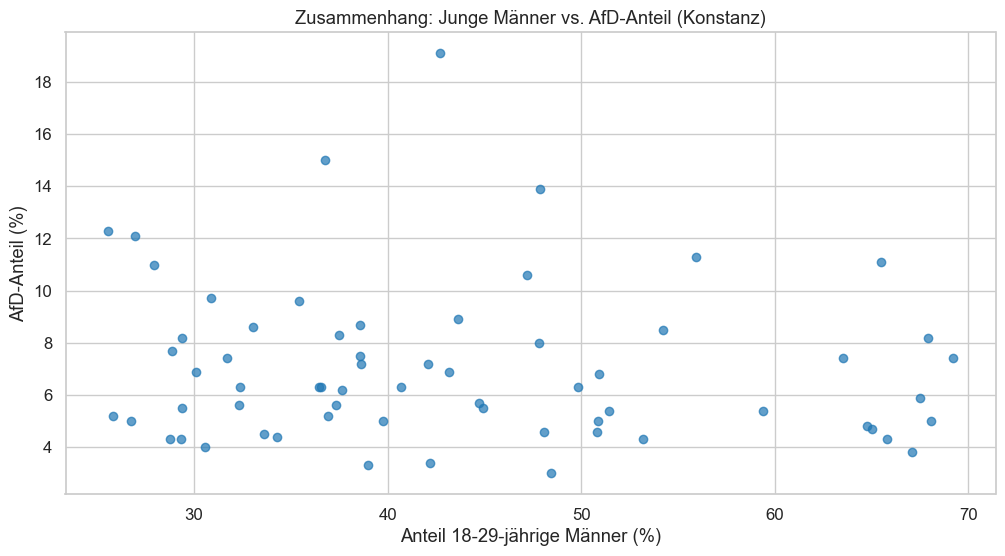

Korrelation Anteil junge Männer vs. AfD: -0.112


In [84]:
# Anteil junger Männer (18-29) am Stadtteil und Jahr berechnen und Zusammenhang mit AfD-Anteil untersuchen
if all(col in df_kn.columns for col in ['einw_hw_18_bis_unter_30', 'einw_hw_gesamt', 'einw_hw_frauen']):
    # Männer gesamt
    df_kn['einw_hw_maenner'] = df_kn['einw_hw_gesamt'] - df_kn['einw_hw_frauen']
    # Anteil junger Männer an allen Männern
    df_kn['anteil_junge_maenner'] = (df_kn['einw_hw_18_bis_unter_30'] / df_kn['einw_hw_maenner']) * 100
    plt.scatter(df_kn['anteil_junge_maenner'], df_kn['AfD'], alpha=0.7)
    plt.xlabel("Anteil 18-29-jährige Männer (%)")
    plt.ylabel("AfD-Anteil (%)")
    plt.title("Zusammenhang: Junge Männer vs. AfD-Anteil (Konstanz)")
    plt.show()
    corr = df_kn[['anteil_junge_maenner', 'AfD']].corr().iloc[0,1]
    print("Korrelation Anteil junge Männer vs. AfD:", round(corr, 3))
else:
    print("Daten für junge Männer nicht verfügbar.")

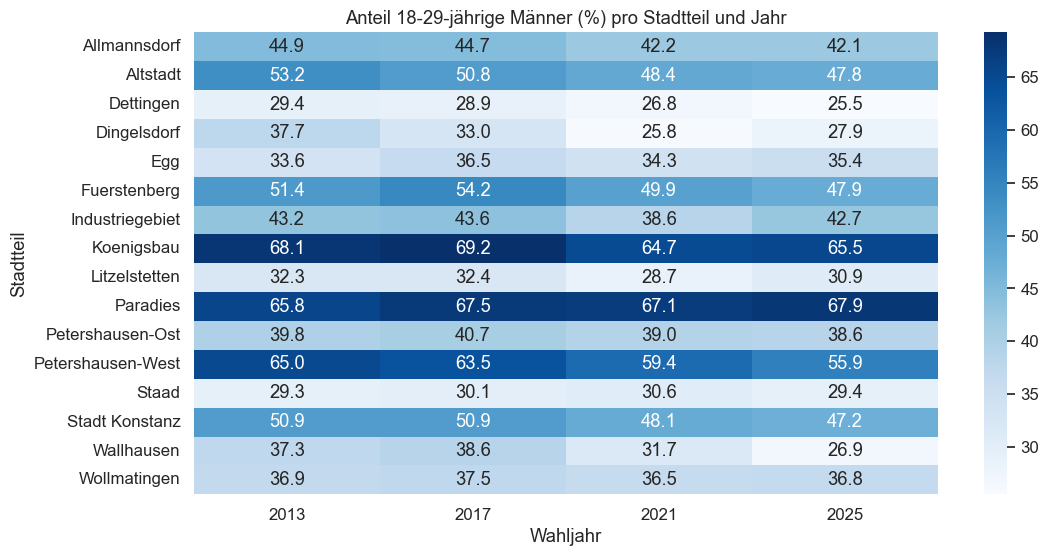

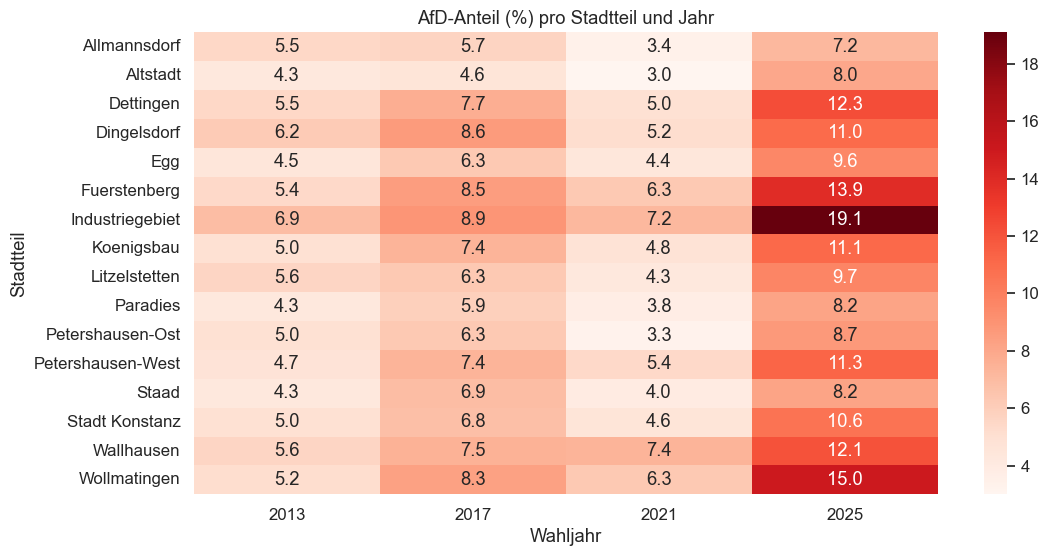

In [85]:
# Pivot-Tabellen für Heatmaps
pivot_junge_maenner = df_kn.pivot_table(index='stadtteil', columns='wahljahr', values='anteil_junge_maenner')
pivot_afd = df_kn.pivot_table(index='stadtteil', columns='wahljahr', values='AfD')

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_junge_maenner, annot=True, fmt=".1f", cmap="Blues")
plt.title("Anteil 18-29-jährige Männer (%) pro Stadtteil und Jahr")
plt.ylabel("Stadtteil")
plt.xlabel("Wahljahr")
plt.show()

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_afd, annot=True, fmt=".1f", cmap="Reds")
plt.title("AfD-Anteil (%) pro Stadtteil und Jahr")
plt.ylabel("Stadtteil")
plt.xlabel("Wahljahr")
plt.show()

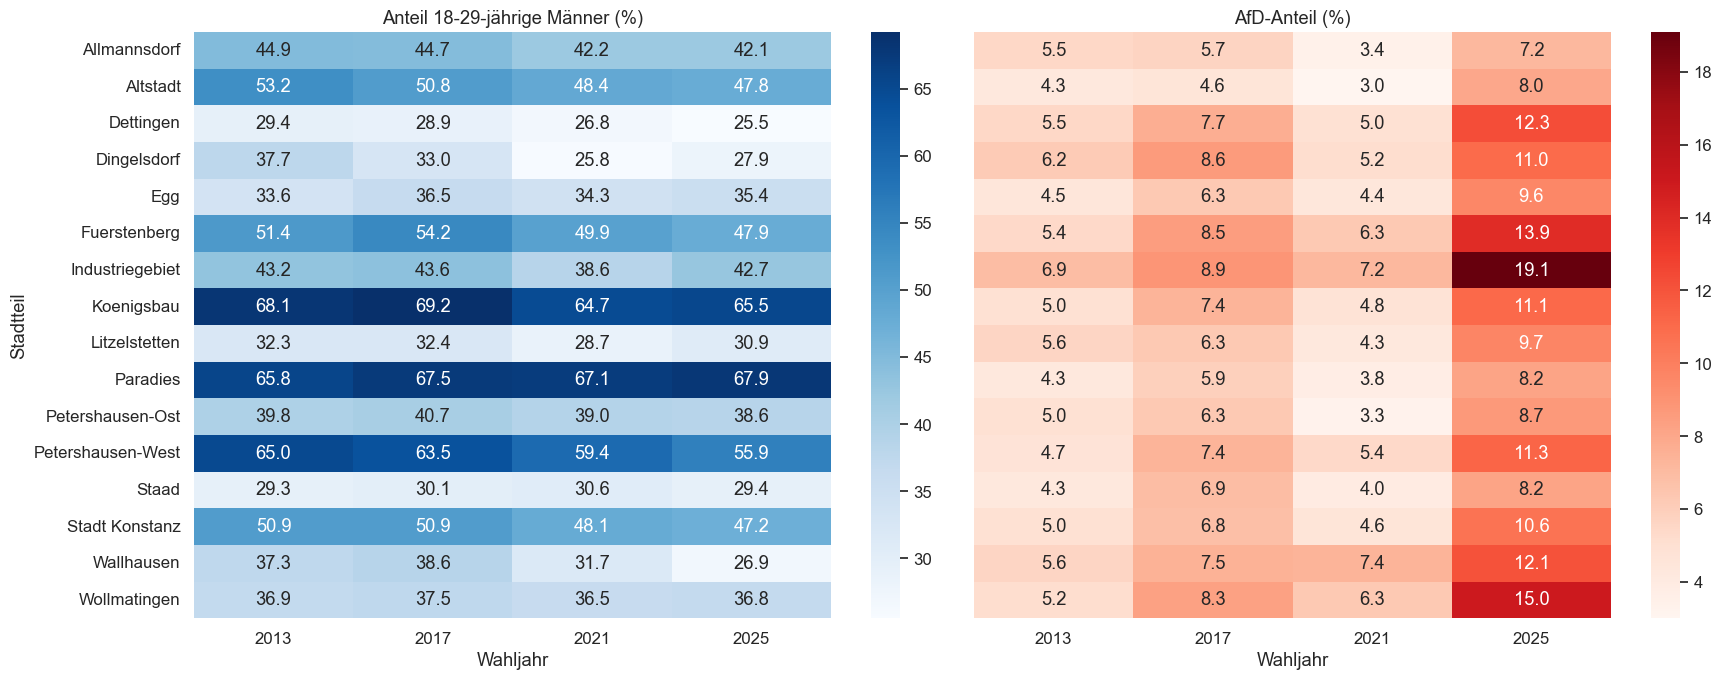

In [86]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

sns.heatmap(pivot_junge_maenner, annot=True, fmt=".1f", cmap="Blues", ax=axes[0])
axes[0].set_title("Anteil 18-29-jährige Männer (%)")
axes[0].set_ylabel("Stadtteil")
axes[0].set_xlabel("Wahljahr")

sns.heatmap(pivot_afd, annot=True, fmt=".1f", cmap="Reds", ax=axes[1])
axes[1].set_title("AfD-Anteil (%)")
axes[1].set_xlabel("Wahljahr")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

/var/folders/xb/3cn73kh15fx078zh0ryb_lrc0000gn/T/ipykernel_9333/698297304.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


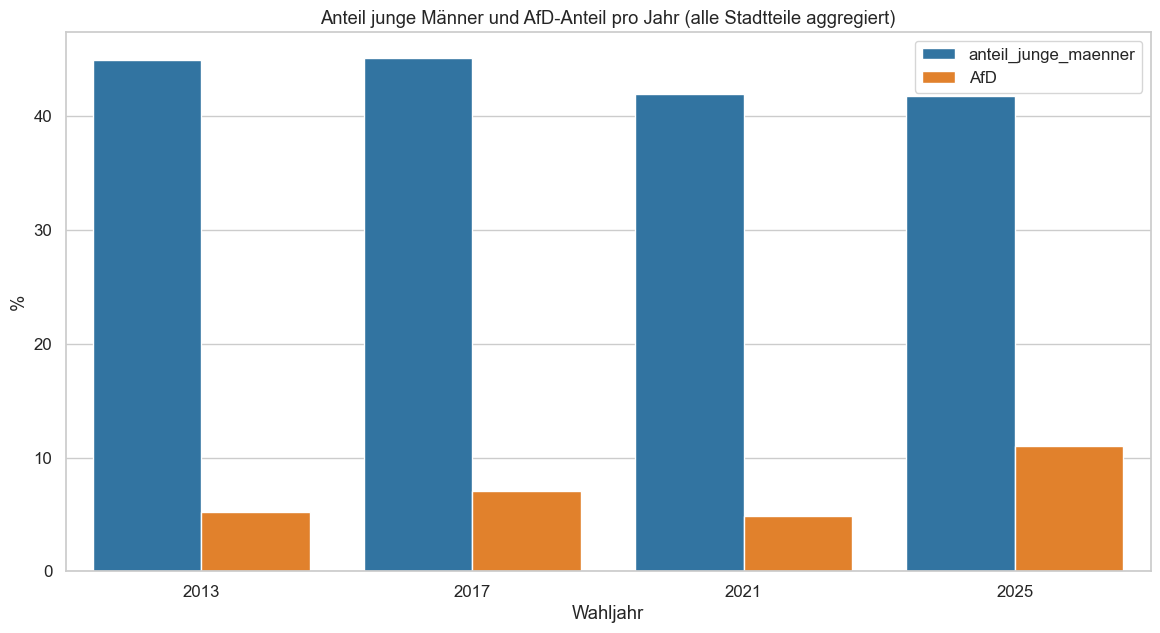

In [87]:
# Daten für Balkendiagramm vorbereiten
df_bar = df_kn[['stadtteil', 'wahljahr', 'anteil_junge_maenner', 'AfD']].dropna()
df_bar = pd.melt(df_bar, id_vars=['stadtteil', 'wahljahr'], value_vars=['anteil_junge_maenner', 'AfD'],
                 var_name='Kategorie', value_name='Prozent')

plt.figure(figsize=(14, 7))
sns.barplot(
    data=df_bar,
    x='wahljahr',
    y='Prozent',
    hue='Kategorie',
    ci=None
)
plt.title("Anteil junge Männer und AfD-Anteil pro Jahr (alle Stadtteile aggregiert)")
plt.ylabel("%")
plt.xlabel("Wahljahr")
plt.legend(title="")
plt.show()

In [88]:
# Für Konstanz: Einflussfaktoren auf AfD-Anteil pro Wahljahr
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression

df_kn['einw_hw_männer'] = df_kn['einw_hw_gesamt'] - df_kn['einw_hw_frauen']


features = [
    'einw_hw_nichtdeutsch', 'einw_hw_18_bis_unter_30', 'einw_hw_30_bis_unter_40', 'einw_hw_40_bis_unter_50'   , 'einw_hw_50_bis_unter_60','einw_hw_männer',
    'einw_hw_60_und_aelter', 'arbeitslose', 'haushalte', 'HH_1-Person','HH_2-Personen', 'HH_3+-Personen', 'religion_katholisch','religion_evangelisch','religion_sonstige', 'einw_hw_frauen'
]

ergebnisse = []
for jahr in df_kn['wahljahr'].unique():
    df_jahr = df_kn[df_kn['wahljahr'] == jahr].dropna(subset=features + ['AfD'])
    X = df_jahr[features]
    y = df_jahr['AfD']
    if len(X) > 2:
        model = LinearRegression().fit(X, y)
        ergebnisse.append({
            'wahljahr': jahr,
            'R2': model.score(X, y),
            'Koeffizienten': dict(zip(features, model.coef_))
        })
df_ergebnisse = pd.DataFrame(ergebnisse)
print("Einflussfaktoren auf AfD-Anteil pro Wahljahr (Konstanz, Stadtteile)")
print(df_ergebnisse)

Einflussfaktoren auf AfD-Anteil pro Wahljahr (Konstanz, Stadtteile)
   wahljahr   R2                                      Koeffizienten
0      2013  1.0  {'einw_hw_nichtdeutsch': 0.013486720243726665,...
1      2017  1.0  {'einw_hw_nichtdeutsch': 0.030635515318770717,...
2      2021  1.0  {'einw_hw_nichtdeutsch': 0.0312296066594674, '...
3      2025  1.0  {'einw_hw_nichtdeutsch': 0.09198297082694411, ...


In [89]:
from sklearn.linear_model import LinearRegression

df_kr['Ausland_gesamt'] = df_kr['Männlich_Ausland'] + df_kr['Weiblich_Ausland']


features = [
     '18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+', 'Evangelisch-reformiert', 'Römisch-katholisch', 'Übrige', 'Männlich_Schweiz', 'Ausland_gesamt', 'Weiblich_Schweiz'
]

# Regression für jede Wahl (Jahr)
ergebnisse = []
for jahr in df_kr['WAHLJAHR'].unique():
    df_jahr = df_kr[df_kr['WAHLJAHR'] == jahr].dropna(subset=features + ['SVP'])
    X = df_jahr[features]
    y = df_jahr['SVP']
    if len(X) > 2:
        model = LinearRegression().fit(X, y)
        ergebnisse.append({
            'WAHLJAHR': jahr,
            'R2': model.score(X, y),
            'Koeffizienten': dict(zip(features, model.coef_))
        })
df_ergebnisse_kr = pd.DataFrame(ergebnisse)
print("Einflussfaktoren auf SVP-Anteil pro Wahljahr (Kreuzlingen, Gemeinden)")
print(df_ergebnisse_kr)

# Gesamtanalyse für alle Gemeinden und Jahre
df_all = df_kr.dropna(subset=features + ['SVP'])
X_all = df_all[features]
y_all = df_all['SVP']
if len(X_all) > 2:
    model_all = LinearRegression().fit(X_all, y_all)
    print("Gesamt (alle Gemeinden und Jahre):")
    print("R2:", model_all.score(X_all, y_all))
    print("Koeffizienten:", dict(zip(features, model_all.coef_)))
    


Einflussfaktoren auf SVP-Anteil pro Wahljahr (Kreuzlingen, Gemeinden)
   WAHLJAHR        R2                                      Koeffizienten
0      2015  0.950056  {'18-29': 0.25933567467682056, '30-39': -0.515...
1      2019  0.898294  {'18-29': 0.8763670381123295, '30-39': 0.19473...
2      2023  0.999362  {'18-29': -0.09988885069740822, '30-39': -1.34...
Gesamt (alle Gemeinden und Jahre):
R2: 0.6556535554125904
Koeffizienten: {'18-29': np.float64(0.30518401277423063), '30-39': np.float64(-0.028088794939958188), '40-49': np.float64(-0.00595926112176919), '50-59': np.float64(0.02793225180809998), '60-69': np.float64(0.027010588611452807), '70-79': np.float64(0.17005273220506495), '80+': np.float64(-0.0233915040784962), 'Evangelisch-reformiert': np.float64(-0.0022794099238787383), 'Römisch-katholisch': np.float64(-0.1000650791575085), 'Übrige': np.float64(0.007019960132428878), 'Männlich_Schweiz': np.float64(-0.02262787299533592), 'Ausland_gesamt': np.float64(-0.03918363247141542), '

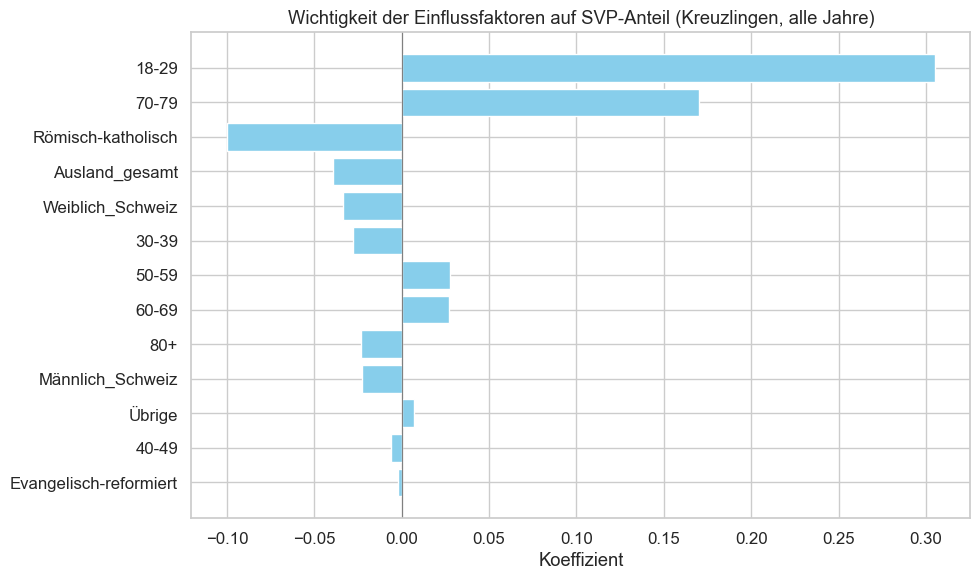

In [90]:
# Wichtigste Einflussfaktoren (Koeffizienten) für alle Jahre und Gemeinden
coef_dict = dict(zip(features, model_all.coef_))
# Nach absolutem Wert sortieren
sorted_coefs = sorted(coef_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Visualisierung
import matplotlib.pyplot as plt

labels, values = zip(*sorted_coefs)
plt.figure(figsize=(10, 6))
bars = plt.barh(labels, values, color='skyblue')
plt.xlabel('Koeffizient')
plt.title('Wichtigkeit der Einflussfaktoren auf SVP-Anteil (Kreuzlingen, alle Jahre)')
plt.gca().invert_yaxis()
plt.axvline(0, color='grey', linewidth=0.8)
plt.tight_layout()
plt.show()

In [91]:
# Welche Jahre sind in df_kn und df_ergebnisse enthalten?
print(sorted(df_kn['wahljahr'].unique()))
print(sorted(df_ergebnisse['wahljahr'].unique()))

[np.int64(2013), np.int64(2017), np.int64(2021), np.int64(2025)]
[np.int64(2013), np.int64(2017), np.int64(2021), np.int64(2025)]


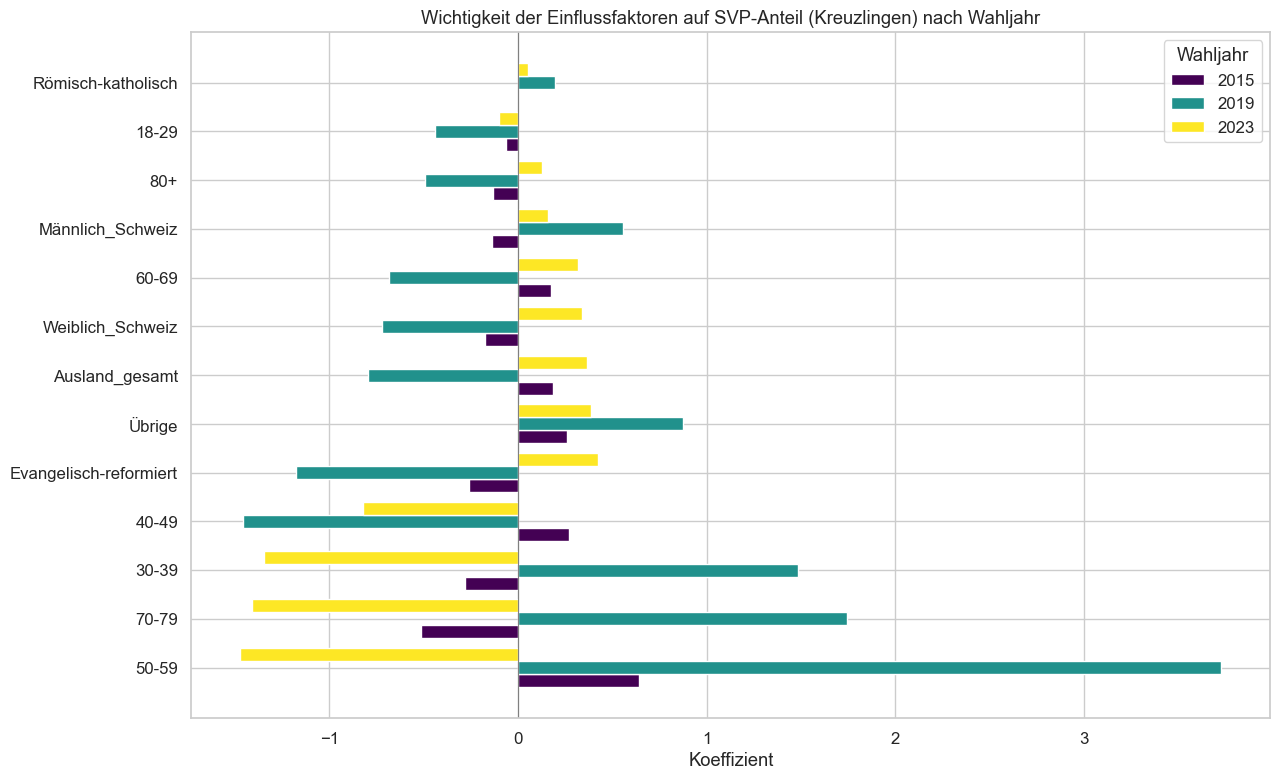

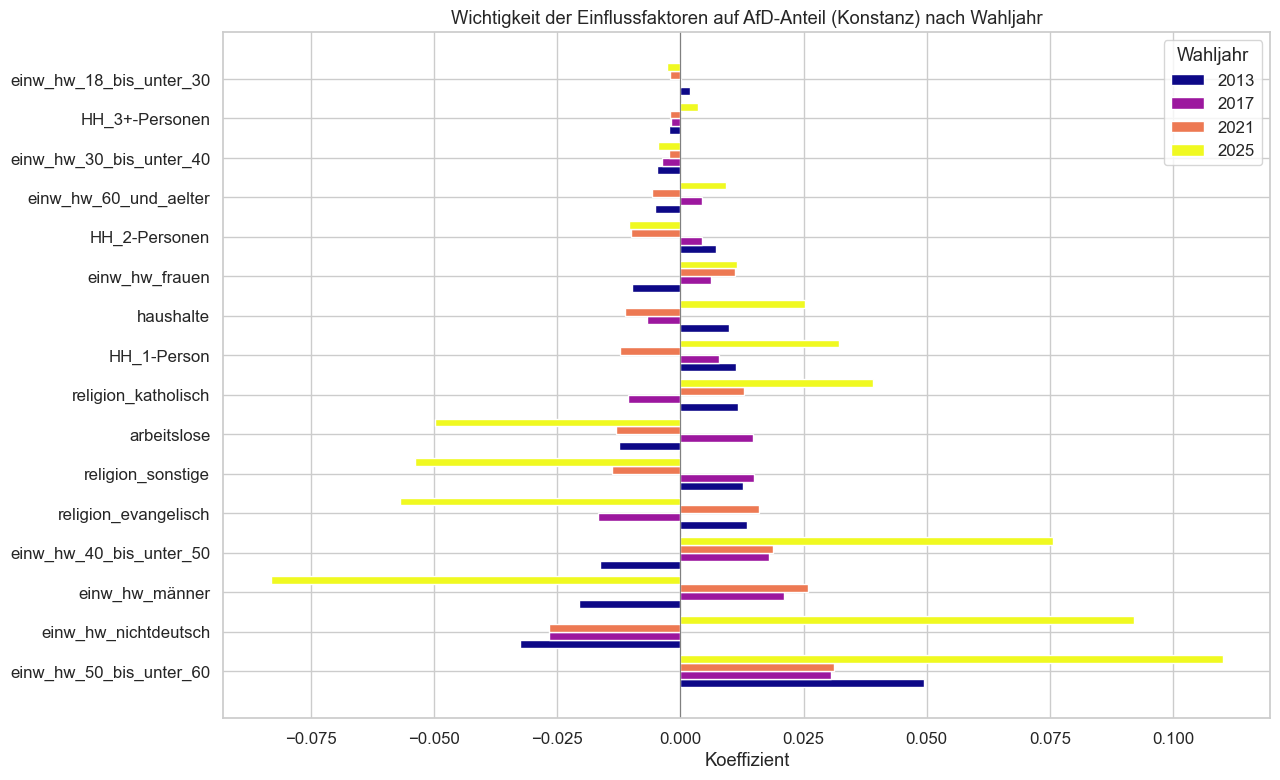

In [92]:
import matplotlib.pyplot as plt
import numpy as np

# --- Kreuzlingen (SVP) ---
jahre_kr = df_ergebnisse_kr['WAHLJAHR'].tolist()
farben_kr = plt.cm.viridis(np.linspace(0, 1, len(jahre_kr)))

plt.figure(figsize=(13, 8))
width = 0.8 / len(jahre_kr)  # Balkenbreite für Gruppierung

for idx, jahr in enumerate(jahre_kr):
    koeffs = df_ergebnisse_kr.loc[df_ergebnisse_kr['WAHLJAHR'] == jahr, 'Koeffizienten'].values[0]
    sorted_items = sorted(koeffs.items(), key=lambda x: abs(x[1]), reverse=True)
    labels, values = zip(*sorted_items)
    y = np.arange(len(labels))
    plt.barh(y + idx * width, values, height=width, color=farben_kr[idx], label=f"{jahr}")

plt.yticks(np.arange(len(labels)) + width * (len(jahre_kr)-1)/2, labels)
plt.xlabel('Koeffizient')
plt.title('Wichtigkeit der Einflussfaktoren auf SVP-Anteil (Kreuzlingen) nach Wahljahr')
plt.axvline(0, color='grey', linewidth=0.8)
plt.legend(title="Wahljahr")
plt.tight_layout()
plt.show()

# --- Konstanz (AfD) ---
jahre_kn = df_ergebnisse['wahljahr'].tolist()
farben_kn = plt.cm.plasma(np.linspace(0, 1, len(jahre_kn)))

plt.figure(figsize=(13, 8))
width = 0.8 / len(jahre_kn)

for idx, jahr in enumerate(jahre_kn):
    koeffs = df_ergebnisse.loc[df_ergebnisse['wahljahr'] == jahr, 'Koeffizienten'].values[0]
    sorted_items = sorted(koeffs.items(), key=lambda x: abs(x[1]), reverse=True)
    labels, values = zip(*sorted_items)
    y = np.arange(len(labels))
    plt.barh(y + idx * width, values, height=width, color=farben_kn[idx], label=f"{jahr}")

plt.yticks(np.arange(len(labels)) + width * (len(jahre_kn)-1)/2, labels)
plt.xlabel('Koeffizient')
plt.title('Wichtigkeit der Einflussfaktoren auf AfD-Anteil (Konstanz) nach Wahljahr')
plt.axvline(0, color='grey', linewidth=0.8)
plt.legend(title="Wahljahr")
plt.tight_layout()
plt.show()

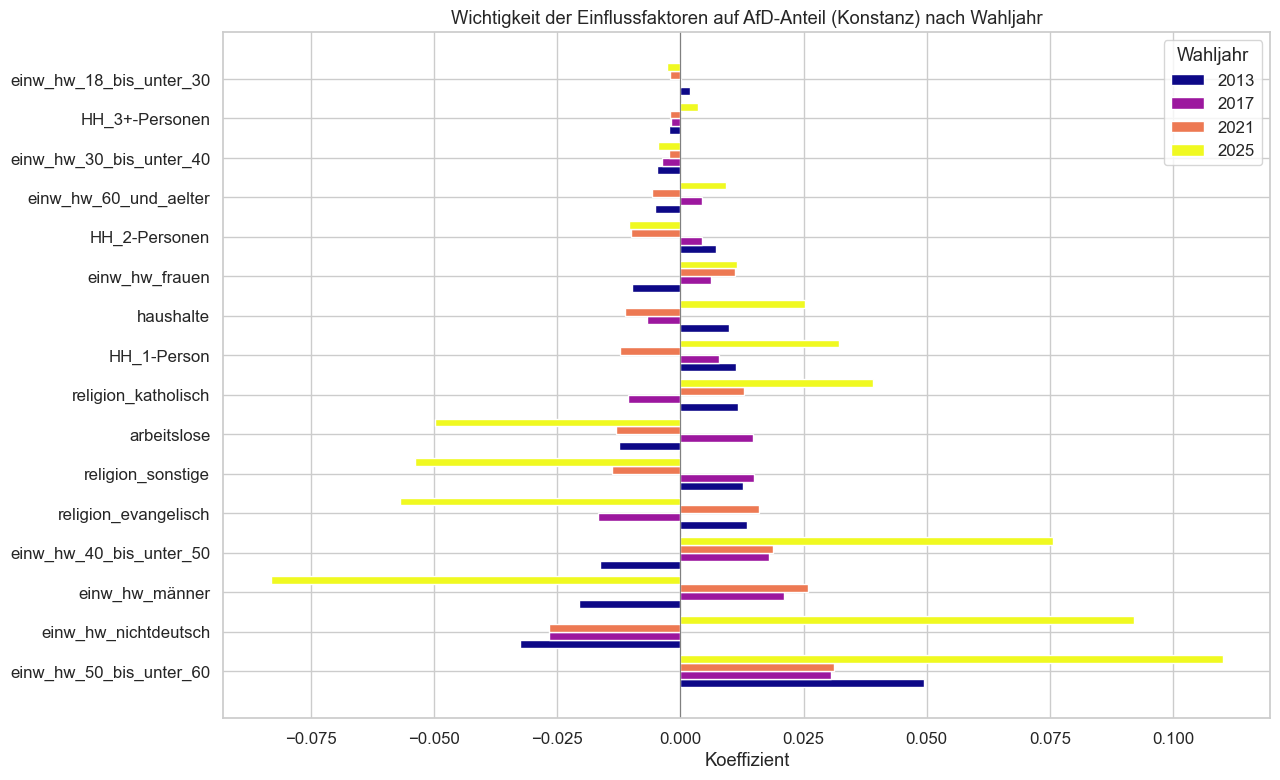

Standardisierte Koeffizienten Konstanz (AfD):
{'einw_hw_nichtdeutsch': np.float64(10.482063603506681), 'einw_hw_18_bis_unter_30': np.float64(-25.466946377483232), 'einw_hw_30_bis_unter_40': np.float64(-27.109263365577846), 'einw_hw_40_bis_unter_50': np.float64(-8.013298897983647), 'einw_hw_50_bis_unter_60': np.float64(-8.536886045549375), 'einw_hw_männer': np.float64(61.33627612659748), 'einw_hw_frauen': np.float64(-1.8448619260927552), 'einw_hw_60_und_aelter': np.float64(-11.561228034541914), 'arbeitslose': np.float64(-7.029300123731112), 'haushalte': np.float64(-8.751397206067757), 'HH_1-Person': np.float64(-0.1565657603889415), 'HH_2-Personen': np.float64(-19.829085781097554), 'HH_3+-Personen': np.float64(-24.941357732965994), 'religion_katholisch': np.float64(26.1319593269016), 'religion_evangelisch': np.float64(6.896746359766303), 'religion_sonstige': np.float64(36.68306869156888)}
Standardisierte Koeffizienten Kreuzlingen (SVP):
{'18-29': np.float64(236.33969298624373), '30-39': 

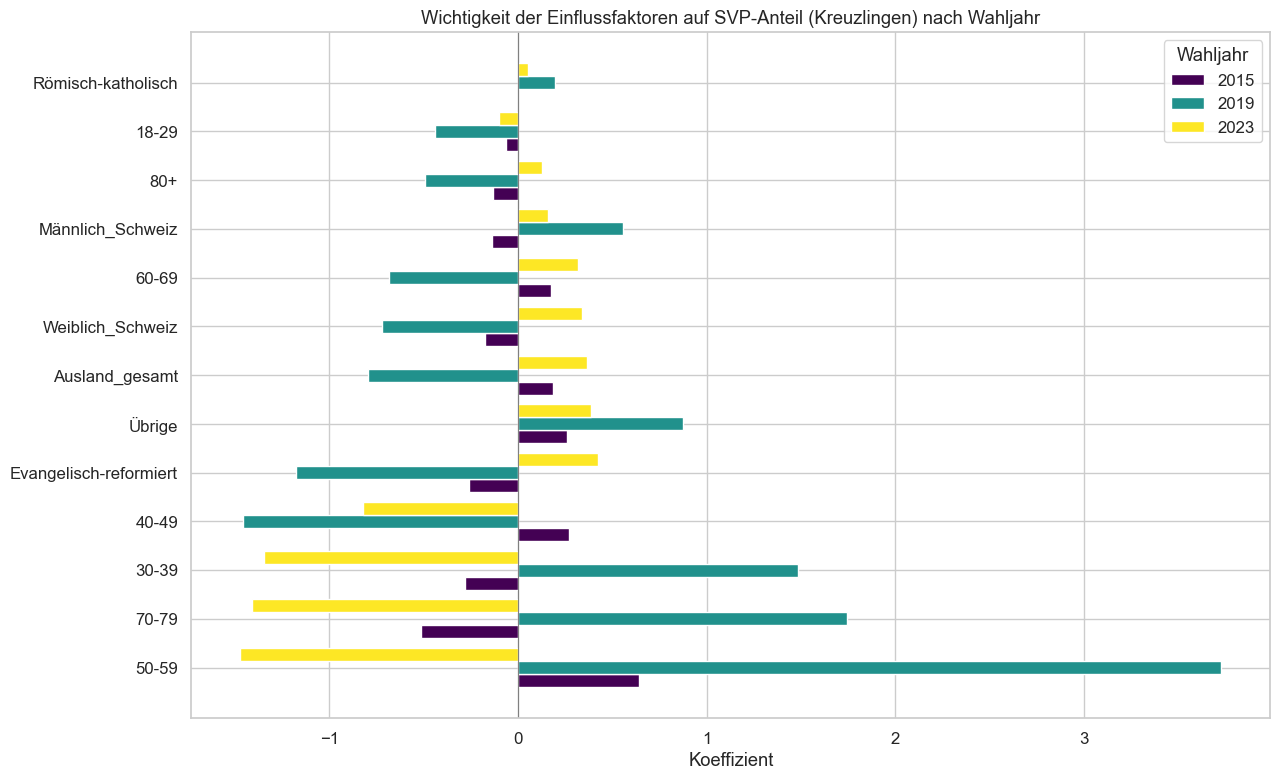

In [93]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# --- Konstanz ---
features_kn = [
    'einw_hw_nichtdeutsch', 'einw_hw_18_bis_unter_30', 'einw_hw_30_bis_unter_40', 'einw_hw_40_bis_unter_50',
    'einw_hw_50_bis_unter_60', 'einw_hw_männer', 'einw_hw_frauen', 'einw_hw_60_und_aelter', 'arbeitslose',
    'haushalte', 'HH_1-Person', 'HH_2-Personen', 'HH_3+-Personen', 'religion_katholisch', 'religion_evangelisch', 'religion_sonstige'
]
df_all_kn = df_kn.dropna(subset=features_kn + ['AfD'])
X_kn = df_all_kn[features_kn]
y_kn = df_all_kn['AfD']

scaler_kn = StandardScaler()
X_kn_scaled = scaler_kn.fit_transform(X_kn)

model_kn = LinearRegression().fit(X_kn_scaled, y_kn)
coef_dict_kn = dict(zip(features_kn, model_kn.coef_))

jahre_kn = df_ergebnisse['wahljahr'].tolist()
farben_kn = plt.cm.plasma(np.linspace(0, 1, len(jahre_kn)))

plt.figure(figsize=(13, 8))
width = 0.8 / len(jahre_kn)

for idx, jahr in enumerate(jahre_kn):
    koeffs = df_ergebnisse.loc[df_ergebnisse['wahljahr'] == jahr, 'Koeffizienten'].values[0]
    sorted_items = sorted(koeffs.items(), key=lambda x: abs(x[1]), reverse=True)
    labels, values = zip(*sorted_items)
    y = np.arange(len(labels))
    plt.barh(y + idx * width, values, height=width, color=farben_kn[idx], label=f"{jahr}")

plt.yticks(np.arange(len(labels)) + width * (len(jahre_kn)-1)/2, labels)
plt.xlabel('Koeffizient')
plt.title('Wichtigkeit der Einflussfaktoren auf AfD-Anteil (Konstanz) nach Wahljahr')
plt.axvline(0, color='grey', linewidth=0.8)
plt.legend(title="Wahljahr")
plt.tight_layout()
plt.show()



# --- Kreuzlingen ---
features_kr = [
    '18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+', 'Evangelisch-reformiert',
    'Römisch-katholisch', 'Übrige', 'Männlich_Schweiz', 'Ausland_gesamt', 'Weiblich_Schweiz'
]
df_all_kr = df_kr.dropna(subset=features_kr + ['SVP'])
X_kr = df_all_kr[features_kr]
y_kr = df_all_kr['SVP']

scaler_kr = StandardScaler()
X_kr_scaled = scaler_kr.fit_transform(X_kr)

model_kr = LinearRegression().fit(X_kr_scaled, y_kr)
coef_dict_kr = dict(zip(features_kr, model_kr.coef_))

# Jetzt sind die Koeffizienten direkt vergleichbar!
print("Standardisierte Koeffizienten Konstanz (AfD):")
print(coef_dict_kn)
print("Standardisierte Koeffizienten Kreuzlingen (SVP):")
print(coef_dict_kr)

jahre_kr = df_ergebnisse_kr['WAHLJAHR'].tolist()
farben_kr = plt.cm.viridis(np.linspace(0, 1, len(jahre_kr)))

plt.figure(figsize=(13, 8))
width = 0.8 / len(jahre_kr)  # Balkenbreite für Gruppierung

for idx, jahr in enumerate(jahre_kr):
    koeffs = df_ergebnisse_kr.loc[df_ergebnisse_kr['WAHLJAHR'] == jahr, 'Koeffizienten'].values[0]
    sorted_items = sorted(koeffs.items(), key=lambda x: abs(x[1]), reverse=True)
    labels, values = zip(*sorted_items)
    y = np.arange(len(labels))
    plt.barh(y + idx * width, values, height=width, color=farben_kr[idx], label=f"{jahr}")

plt.yticks(np.arange(len(labels)) + width * (len(jahre_kr)-1)/2, labels)
plt.xlabel('Koeffizient')
plt.title('Wichtigkeit der Einflussfaktoren auf SVP-Anteil (Kreuzlingen) nach Wahljahr')
plt.axvline(0, color='grey', linewidth=0.8)
plt.legend(title="Wahljahr")
plt.tight_layout()
plt.show()

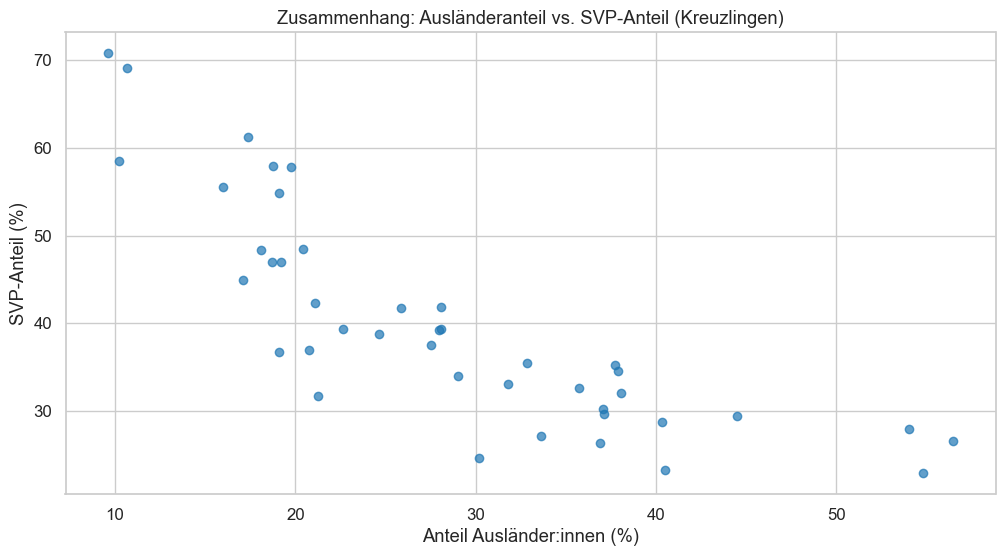

Korrelation Ausländeranteil vs. SVP-Anteil: -0.821


In [132]:
# Anteil Ausländer:innen an der Gesamtbevölkerung berechnen
df_kr['Anteil_Auslaender (%)'] = 100 * df_kr['Ausland_gesamt'] / df_kr['gesamtbevölkerung']

plt.scatter(df_kr['Anteil_Auslaender (%)'], df_kr['SVP'], alpha=0.7)
plt.xlabel("Anteil Ausländer:innen (%)")
plt.ylabel("SVP-Anteil (%)")
plt.title("Zusammenhang: Ausländeranteil vs. SVP-Anteil (Kreuzlingen)")
plt.show()

# Korrelation berechnen
cor = df_kr[['Anteil_Auslaender (%)', 'SVP']].corr().iloc[0,1]
print(f"Korrelation Ausländeranteil vs. SVP-Anteil: {cor:.3f}")

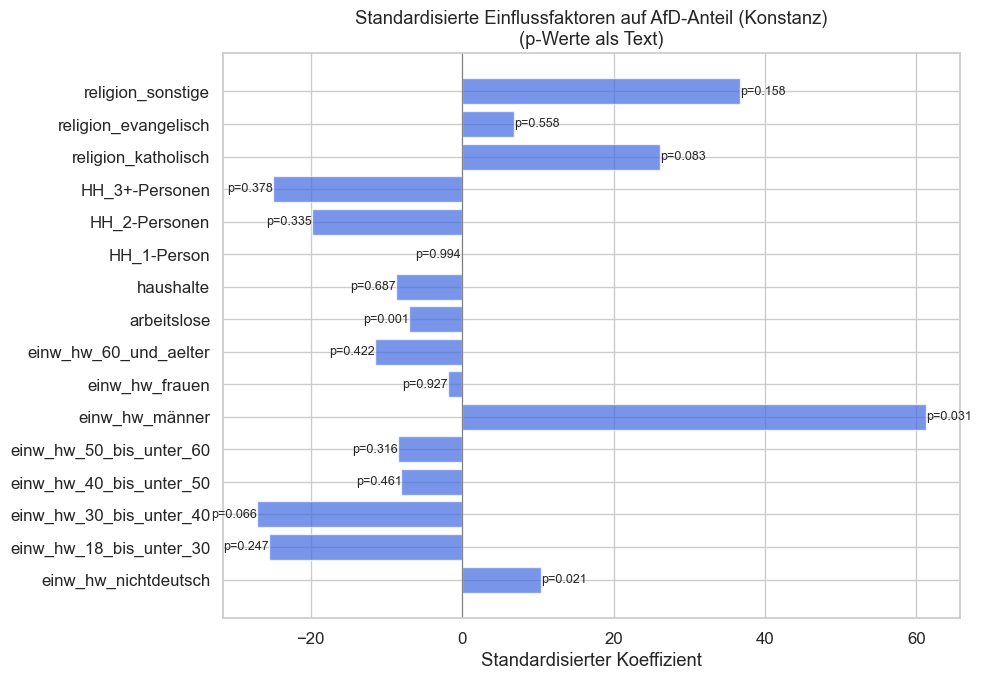

Standardisierte Koeffizienten und p-Werte Konstanz (AfD):
{'einw_hw_nichtdeutsch': (10.482063603506724, 0.020970225171532648), 'einw_hw_18_bis_unter_30': (-25.466946377484085, 0.24708986113461293), 'einw_hw_30_bis_unter_40': (-27.109263365578578, 0.06642725190423501), 'einw_hw_40_bis_unter_50': (-8.013298897984, 0.46109757574659893), 'einw_hw_50_bis_unter_60': (-8.536886045549753, 0.31583182468105925), 'einw_hw_männer': (61.336276126598904, 0.03148530901252486), 'einw_hw_frauen': (-1.84486192609217, 0.9266485577348863), 'einw_hw_60_und_aelter': (-11.561228034542454, 0.42159936409996857), 'arbeitslose': (-7.029300123731211, 0.0008664368248531768), 'haushalte': (-8.751397206068354, 0.6865307910082638), 'HH_1-Person': (-0.15656576038880843, 0.9940493763807834), 'HH_2-Personen': (-19.82908578109793, 0.33526291451342727), 'HH_3+-Personen': (-24.941357732966765, 0.3783092193259071), 'religion_katholisch': (26.13195932690248, 0.08257770594996626), 'religion_evangelisch': (6.896746359766674, 0

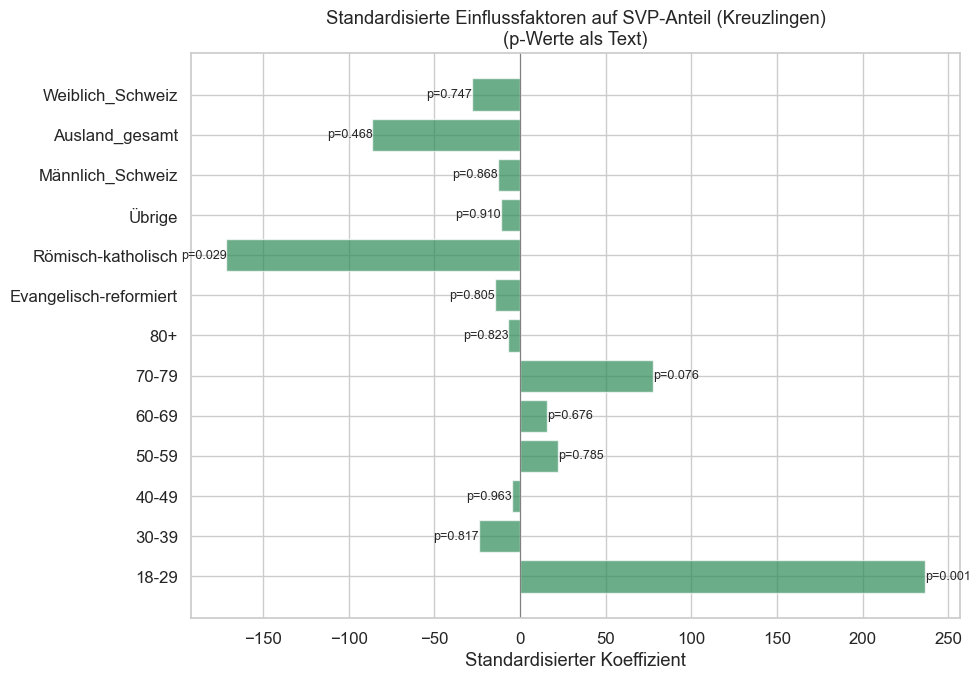

Standardisierte Koeffizienten und p-Werte Kreuzlingen (SVP):
{'18-29': (236.3396929862442, 0.0006705475825992647), '30-39': (-23.909616145740102, 0.8171137886035662), '40-49': (-4.517261494364675, 0.9633274517348805), '50-59': (22.154023516753227, 0.7853332109512432), '60-69': (16.080599327803554, 0.6761202921159049), '70-79': (77.66961840724144, 0.07601470316921859), '80+': (-6.651623807184322, 0.8230298414601042), 'Evangelisch-reformiert': (-14.455819458042242, 0.8051779436978277), 'Römisch-katholisch': (-171.33448147670128, 0.02906788418056065), 'Übrige': (-10.91622183598514, 0.9096308614427187), 'Männlich_Schweiz': (-12.671987521480844, 0.8677721655315755), 'Ausland_gesamt': (-86.01489757014889, 0.4677507180073279), 'Weiblich_Schweiz': (-27.762698457123975, 0.7465432679383927)}


In [94]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

# --- Konstanz ---
features_kn = [
    'einw_hw_nichtdeutsch', 'einw_hw_18_bis_unter_30', 'einw_hw_30_bis_unter_40', 'einw_hw_40_bis_unter_50',
    'einw_hw_50_bis_unter_60', 'einw_hw_männer', 'einw_hw_frauen', 'einw_hw_60_und_aelter', 'arbeitslose',
    'haushalte', 'HH_1-Person', 'HH_2-Personen', 'HH_3+-Personen', 'religion_katholisch', 'religion_evangelisch', 'religion_sonstige'
]
df_all_kn = df_kn.dropna(subset=features_kn + ['AfD'])
X_kn = df_all_kn[features_kn]
y_kn = df_all_kn['AfD']

scaler_kn = StandardScaler()
X_kn_scaled = scaler_kn.fit_transform(X_kn)
X_kn_scaled = sm.add_constant(X_kn_scaled)  # für Intercept

model_kn = sm.OLS(y_kn, X_kn_scaled).fit()
coefs_kn = model_kn.params[1:]  # ohne Intercept
pvals_kn = model_kn.pvalues[1:]
labels_kn = features_kn

# Visualisierung
plt.figure(figsize=(10, 7))
y = np.arange(len(labels_kn))
plt.barh(y, coefs_kn, color='royalblue', alpha=0.7)
for i, (coef, pval) in enumerate(zip(coefs_kn, pvals_kn)):
    plt.text(coef, i, f"p={pval:.3f}", va='center', ha='left' if coef > 0 else 'right', fontsize=9)
plt.yticks(y, labels_kn)
plt.xlabel('Standardisierter Koeffizient')
plt.title('Standardisierte Einflussfaktoren auf AfD-Anteil (Konstanz)\n(p-Werte als Text)')
plt.axvline(0, color='grey', linewidth=0.8)
plt.tight_layout()
plt.show()

print("Standardisierte Koeffizienten und p-Werte Konstanz (AfD):")
print(dict(zip(labels_kn, zip(coefs_kn, pvals_kn))))

# --- Kreuzlingen ---
features_kr = [
    '18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+', 'Evangelisch-reformiert',
    'Römisch-katholisch', 'Übrige', 'Männlich_Schweiz', 'Ausland_gesamt', 'Weiblich_Schweiz'
]
df_all_kr = df_kr.dropna(subset=features_kr + ['SVP'])
X_kr = df_all_kr[features_kr]
y_kr = df_all_kr['SVP']

scaler_kr = StandardScaler()
X_kr_scaled = scaler_kr.fit_transform(X_kr)
X_kr_scaled = sm.add_constant(X_kr_scaled)

model_kr = sm.OLS(y_kr, X_kr_scaled).fit()
coefs_kr = model_kr.params[1:]
pvals_kr = model_kr.pvalues[1:]
labels_kr = features_kr

plt.figure(figsize=(10, 7))
y = np.arange(len(labels_kr))
plt.barh(y, coefs_kr, color='seagreen', alpha=0.7)
for i, (coef, pval) in enumerate(zip(coefs_kr, pvals_kr)):
    plt.text(coef, i, f"p={pval:.3f}", va='center', ha='left' if coef > 0 else 'right', fontsize=9)
plt.yticks(y, labels_kr)
plt.xlabel('Standardisierter Koeffizient')
plt.title('Standardisierte Einflussfaktoren auf SVP-Anteil (Kreuzlingen)\n(p-Werte als Text)')
plt.axvline(0, color='grey', linewidth=0.8)
plt.tight_layout()
plt.show()

print("Standardisierte Koeffizienten und p-Werte Kreuzlingen (SVP):")
print(dict(zip(labels_kr, zip(coefs_kr, pvals_kr))))


1. Datenbasis
Konstanz:
Es wird der DataFrame df_kn verwendet, der alle verfügbaren Datenpunkte (über alle Stadtteile und Jahre) enthält.
Die Zielvariable ist der AfD-Anteil ('AfD').
Die erklärenden Variablen sind die in features_kn gelisteten demographischen Merkmale (z.B. Altersgruppen, Geschlecht, Haushaltsgrößen, Religion, Arbeitslose).

Kreuzlingen:
Analog wird df_kr verwendet, Zielvariable ist der SVP-Anteil ('SVP'), erklärende Variablen sind features_kr (Altersgruppen, Religion, Geschlecht, Ausland/Schweiz).

Wichtig:
Es werden nur die Zeilen verwendet, in denen für alle Merkmale und die Zielvariable Werte vorhanden sind (dropna(subset=...)).

2. Standardisierung
Die erklärenden Variablen (Features) werden mit StandardScaler() standardisiert (Mittelwert = 0, Standardabweichung = 1).
Dadurch sind die Regressionskoeffizienten direkt vergleichbar, unabhängig von der ursprünglichen Maßeinheit.
3. Regression
Es wird eine multiple lineare Regression mit statsmodels.OLS gerechnet:
Für Konstanz:
AfD = β0 + β1*Feature1 + β2*Feature2 + ... + βn*Featuren + Fehler
Für Kreuzlingen:
SVP = β0 + β1*Feature1 + ... + βn*Featuren + Fehler
Das Modell schätzt für jedes Merkmal einen standardisierten Koeffizienten (β), der angibt, wie stark sich der Wahlanteil verändert, wenn das Merkmal um eine Standardabweichung steigt (bei konstanten anderen Merkmalen).
4. Ergebnisse
Die Koeffizienten (coefs_kn, coefs_kr) zeigen die Richtung und Stärke des Zusammenhangs:
Positiv: Merkmal erhöht den Wahlanteil.
Negativ: Merkmal senkt den Wahlanteil.
Die p-Werte (pvals_kn, pvals_kr) zeigen, ob der Zusammenhang statistisch signifikant ist (meist: p < 0.05 = signifikant).
5. Visualisierung
Es wird ein Balkendiagramm erstellt, das für jedes Merkmal den standardisierten Koeffizienten zeigt.
Die p-Werte werden als Text neben die Balken geschrieben.
6. Zusammengefasst:
Welche Daten?
Alle Zeilen aus df_kn bzw. df_kr, für die alle Merkmale und die Zielvariable vorhanden sind (über alle Stadtteile und Jahre aggregiert).
Was wird berechnet?
Der Einfluss (standardisierter Koeffizient) jedes Merkmals auf den AfD- bzw. SVP-Anteil, kontrolliert für alle anderen Merkmale.
Wie ist das zu interpretieren?
Ein hoher positiver Wert bedeutet: Steigt das Merkmal um eine Standardabweichung, steigt der Wahlanteil entsprechend.
Ein negativer Wert: Steigt das Merkmal, sinkt der Wahlanteil.

In [95]:
for jahr in df_kn['wahljahr'].unique():
    df_jahr = df_kn[df_kn['wahljahr'] == jahr].dropna(subset=features_kn + ['AfD'])
    if len(df_jahr) > len(features_kn) + 1:
        X = df_jahr[features_kn]
        y = df_jahr['AfD']
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X_scaled = sm.add_constant(X_scaled)
        model = sm.OLS(y, X_scaled).fit()
        print(f"Koeffizienten für Jahr {jahr}:")
        print(dict(zip(features_kn, model.params[1:])))
    else: print('not enough data')

not enough data
not enough data
not enough data
not enough data


In [96]:
# Für alle Stadtteile (Konstanz) und Gemeinden (Kreuzlingen): Standardisierte Koeffizienten-Tabelle

import pandas as pd
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

# --- Konstanz: Für jeden Stadtteil ---
results_kn = []
features_kn = [
    'einw_hw_nichtdeutsch', 'einw_hw_18_bis_unter_30', 'einw_hw_30_bis_unter_40', 'einw_hw_40_bis_unter_50',
    'einw_hw_50_bis_unter_60', 'einw_hw_männer', 'einw_hw_frauen', 'einw_hw_60_und_aelter', 'arbeitslose',
    'haushalte', 'HH_1-Person', 'HH_2-Personen', 'HH_3+-Personen', 'religion_katholisch', 'religion_evangelisch', 'religion_sonstige'
]
for stadtteil in df_kn['stadtteil'].unique():
    df_st = df_kn[df_kn['stadtteil'] == stadtteil].dropna(subset=features_kn + ['AfD'])
    if len(df_st) > len(features_kn) + 1:
        X = df_st[features_kn]
        y = df_st['AfD']
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X_scaled = sm.add_constant(X_scaled)
        model = sm.OLS(y, X_scaled).fit()
        for feat, coef, pval in zip(features_kn, model.params[1:], model.pvalues[1:]):
            results_kn.append({
                'Region': stadtteil,
                'Feature': feat,
                'Koeffizient': coef,
                'p-Wert': pval
            })

df_kn_coef = pd.DataFrame(results_kn)

# --- Kreuzlingen: Für jede Gemeinde ---
results_kr = []
features_kr = [
    '18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+', 'Evangelisch-reformiert',
    'Römisch-katholisch', 'Übrige', 'Männlich_Schweiz', 'Ausland_gesamt', 'Weiblich_Schweiz'
]
for gemeinde in df_kr['GEMEINDE_NAME'].unique():
    df_g = df_kr[df_kr['GEMEINDE_NAME'] == gemeinde].dropna(subset=features_kr + ['SVP'])
    if len(df_g) > len(features_kr) + 1:
        X = df_g[features_kr]
        y = df_g['SVP']
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X_scaled = sm.add_constant(X_scaled)
        model = sm.OLS(y, X_scaled).fit()
        for feat, coef, pval in zip(features_kr, model.params[1:], model.pvalues[1:]):
            results_kr.append({
                'Region': gemeinde,
                'Feature': feat,
                'Koeffizient': coef,
                'p-Wert': pval
            })

df_kr_coef = pd.DataFrame(results_kr)

# Beispiel: Zeige die ersten Zeilen für Konstanz und Kreuzlingen
display(df_kn_coef.head())
display(df_kr_coef.head())

Empty DataFrame
Columns: []
Index: []

Empty DataFrame
Columns: []
Index: []

In [97]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X = df_all_kn[features_kn]
y = df_all_kn['AfD']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
print("Test R2:", rf.score(X_test, y_test))
print("Feature Importances:", dict(zip(features_kn, rf.feature_importances_)))

Test R2: -0.07374165842002478
Feature Importances: {'einw_hw_nichtdeutsch': np.float64(0.0677945964085846), 'einw_hw_18_bis_unter_30': np.float64(0.029281281942555953), 'einw_hw_30_bis_unter_40': np.float64(0.04003769842753631), 'einw_hw_40_bis_unter_50': np.float64(0.030430858707519458), 'einw_hw_50_bis_unter_60': np.float64(0.03537883260992354), 'einw_hw_männer': np.float64(0.026504926851666836), 'einw_hw_frauen': np.float64(0.01452721239419858), 'einw_hw_60_und_aelter': np.float64(0.04017261142810206), 'arbeitslose': np.float64(0.06613570566455822), 'haushalte': np.float64(0.015557998329600359), 'HH_1-Person': np.float64(0.018690695797533092), 'HH_2-Personen': np.float64(0.022663023389794427), 'HH_3+-Personen': np.float64(0.0776705750485836), 'religion_katholisch': np.float64(0.21158149886457053), 'religion_evangelisch': np.float64(0.26962292352723327), 'religion_sonstige': np.float64(0.03394956060803921)}


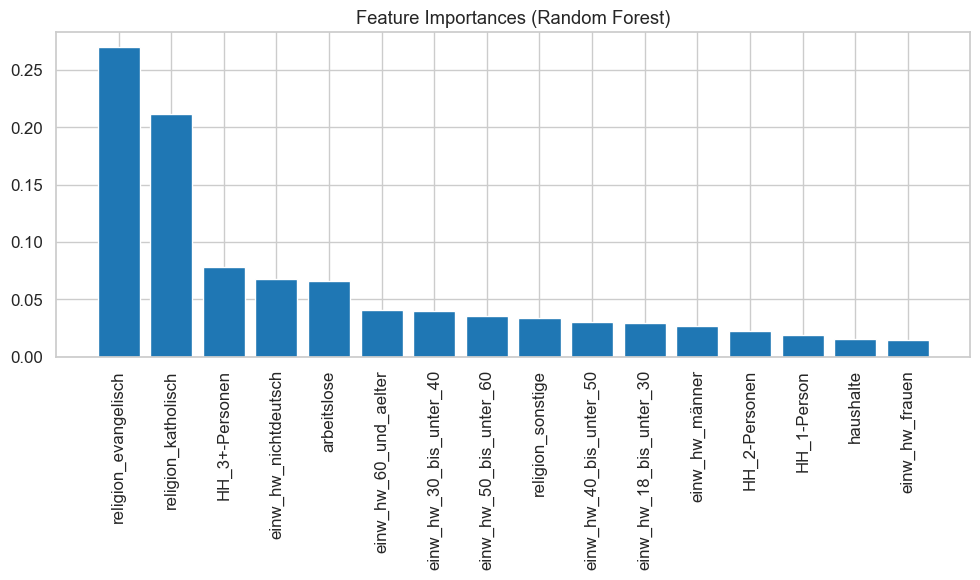

In [98]:
import matplotlib.pyplot as plt

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(len(features_kn)), importances[indices], align="center")
plt.xticks(range(len(features_kn)), [features_kn[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

Test R2: 0.800718015337659
Feature Importances: {'18-29': np.float64(0.03300727054293705), '30-39': np.float64(0.03576925241903297), '40-49': np.float64(0.02155861966030328), '50-59': np.float64(0.12966532572029169), '60-69': np.float64(0.03802575658972206), '70-79': np.float64(0.05501814069627201), '80+': np.float64(0.08532572592856084), 'Evangelisch-reformiert': np.float64(0.040493005075586785), 'Römisch-katholisch': np.float64(0.32651461128363674), 'Übrige': np.float64(0.033631072130650835), 'Männlich_Schweiz': np.float64(0.02775680149215903), 'Ausland_gesamt': np.float64(0.13680021410944332), 'Weiblich_Schweiz': np.float64(0.03643420435140335)}


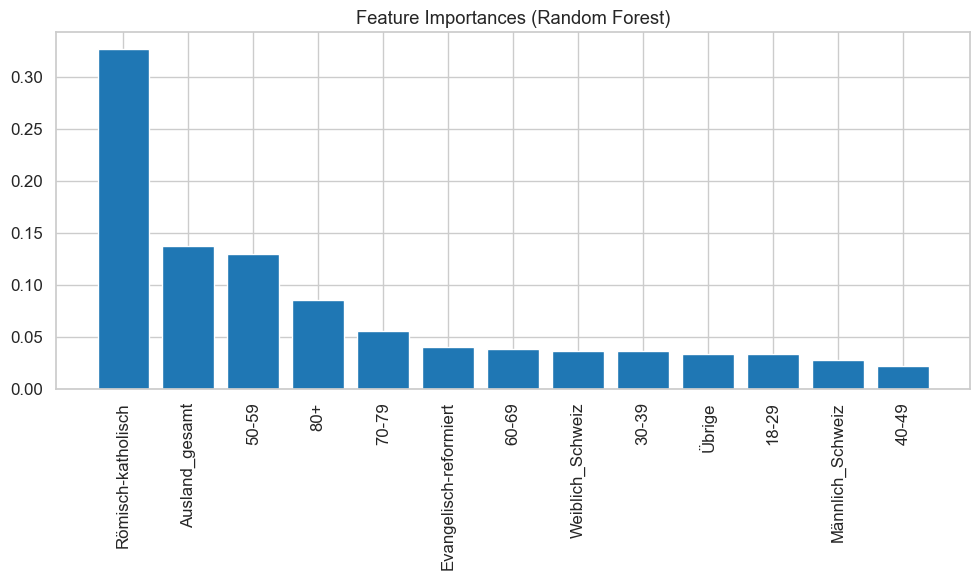

In [99]:

X = df_all_kr[features_kr]
y = df_all_kr['SVP']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
print("Test R2:", rf.score(X_test, y_test))
print("Feature Importances:", dict(zip(features_kr, rf.feature_importances_)))


importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(len(features_kr)), importances[indices], align="center")
plt.xticks(range(len(features_kr)), [features_kr[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

Die beiden Visualisierungen zeigen die Feature Importances (Merkmalswichtigkeit) aus dem Random Forest Modell für:

Konstanz (AfD-Anteil, linke Grafik):
Die wichtigsten Merkmale für die Vorhersage des AfD-Anteils sind hier z.B. „religion_evangelisch“, „religion_katholisch“ und „HH_3+-Personen“. Je höher der Balken, desto stärker nutzt das Modell dieses Merkmal für die Vorhersage.

Kreuzlingen (SVP-Anteil, rechte Grafik):
Hier ist z.B. „Römisch-katholisch“ das wichtigste Merkmal, gefolgt von „Ausland_gesamt“ und „50-59“. Auch hier gilt: Je höher der Balken, desto wichtiger das Merkmal für das Modell.

Test R2:

Kreuzlingen: Test R2: 0.80
Das Modell erklärt 80 % der Varianz im SVP-Anteil – sehr gute Vorhersagekraft.
Konstanz: Test R2: -0.07
Das Modell ist schlechter als der Mittelwert (schlechte Vorhersagekraft, evtl. zu wenig Daten oder ungeeignete Features).
Fazit:

In Kreuzlingen kann der SVP-Anteil mit den gewählten Merkmalen gut vorhergesagt werden.
In Konstanz gelingt das mit diesen Features und diesem Modell nicht – evtl. sind die Zusammenhänge komplexer oder die Datenbasis zu klein.

In [100]:
for stadtteil in df_kn['stadtteil'].unique():
    print(stadtteil, len(df_kn[df_kn['stadtteil'] == stadtteil]))

Stadt Konstanz 4
Altstadt 4
Paradies 4
Petershausen-West 4
Petershausen-Ost 4
Koenigsbau 4
Allmannsdorf 4
Staad 4
Fuerstenberg 4
Wollmatingen 4
Industriegebiet 4
Egg 4
Litzelstetten 4
Dingelsdorf 4
Dettingen 4
Wallhausen 4


In [101]:
for stadtteil in df_kn['stadtteil'].unique():
    print(f"{stadtteil}: {len(df_kn[df_kn['stadtteil'] == stadtteil])} Zeilen")
for gemeinde in df_kr['GEMEINDE_NAME'].unique():
    print(f"{gemeinde}: {len(df_kr[df_kr['GEMEINDE_NAME'] == gemeinde])} Zeilen")

Stadt Konstanz: 4 Zeilen
Altstadt: 4 Zeilen
Paradies: 4 Zeilen
Petershausen-West: 4 Zeilen
Petershausen-Ost: 4 Zeilen
Koenigsbau: 4 Zeilen
Allmannsdorf: 4 Zeilen
Staad: 4 Zeilen
Fuerstenberg: 4 Zeilen
Wollmatingen: 4 Zeilen
Industriegebiet: 4 Zeilen
Egg: 4 Zeilen
Litzelstetten: 4 Zeilen
Dingelsdorf: 4 Zeilen
Dettingen: 4 Zeilen
Wallhausen: 4 Zeilen
Altnau: 3 Zeilen
Bottighofen: 3 Zeilen
Ermatingen: 3 Zeilen
Gottlieben: 3 Zeilen
Güttingen: 3 Zeilen
Kemmental: 3 Zeilen
Kreuzlingen: 3 Zeilen
Langrickenbach: 3 Zeilen
Lengwil: 3 Zeilen
Münsterlingen: 3 Zeilen
Raperswilen: 3 Zeilen
Salenstein: 3 Zeilen
Tägerwilen: 3 Zeilen
Wäldi: 3 Zeilen


Der standardisierte Koeffizient (auch "Beta-Koeffizient" genannt) gibt an, wie stark sich die Zielvariable (z.B. AfD- oder SVP-Anteil) verändert, wenn das jeweilige Merkmal um eine Standardabweichung steigt, während alle anderen Variablen konstant gehalten werden.

Das bedeutet konkret:

Ein Wert von +0.5 heißt: Steigt das Merkmal um eine Standardabweichung, steigt der Wahlanteil im Mittel um 0.5 Einheiten (z.B. Prozentpunkte, je nach Zielvariable).
Ein Wert von -0.5 heißt: Steigt das Merkmal um eine Standardabweichung, sinkt der Wahlanteil im Mittel um 0.5 Einheiten.
Die Standardisierung macht die Effekte vergleichbar: Ein Koeffizient von 0.5 bei "Arbeitslose" ist genauso stark wie 0.5 bei "Nichtdeutsche", unabhängig von deren ursprünglicher Maßeinheit oder Streuung.


In [102]:
# --- Standardisierte Koeffizienten für alle Stadtteile (Konstanz) ---
import pandas as pd
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

features_kn = [
    'einw_hw_nichtdeutsch', 'einw_hw_18_bis_unter_30', 'einw_hw_30_bis_unter_40', 'einw_hw_40_bis_unter_50',
    'einw_hw_50_bis_unter_60', 'einw_hw_männer', 'einw_hw_frauen', 'einw_hw_60_und_aelter', 'arbeitslose',
    'haushalte', 'HH_1-Person', 'HH_2-Personen', 'HH_3+-Personen', 'religion_katholisch', 'religion_evangelisch', 'religion_sonstige'
]

results_kn = []
for stadtteil in df_kn['stadtteil'].unique():
    df_st = df_kn[df_kn['stadtteil'] == stadtteil].dropna(subset=features_kn + ['AfD'])
    if len(df_st) > len(features_kn) + 1:
        X = df_st[features_kn]
        y = df_st['AfD']
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X_scaled = sm.add_constant(X_scaled)
        model = sm.OLS(y, X_scaled).fit()
        for feat, coef, pval in zip(features_kn, model.params[1:], model.pvalues[1:]):
            results_kn.append({
                'Region': stadtteil,
                'Feature': feat,
                'Koeffizient': coef,
                'p-Wert': pval
            })

df_kn_coef = pd.DataFrame(results_kn)

# --- Standardisierte Koeffizienten für alle Gemeinden (Kreuzlingen) ---
features_kr = [
    '18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+', 'Evangelisch-reformiert',
    'Römisch-katholisch', 'Übrige', 'Männlich_Schweiz', 'Ausland_gesamt', 'Weiblich_Schweiz'
]

results_kr = []
for gemeinde in df_kr['GEMEINDE_NAME'].unique():
    df_g = df_kr[df_kr['GEMEINDE_NAME'] == gemeinde].dropna(subset=features_kr + ['SVP'])
    if len(df_g) > len(features_kr) + 1:
        X = df_g[features_kr]
        y = df_g['SVP']
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X_scaled = sm.add_constant(X_scaled)
        model = sm.OLS(y, X_scaled).fit()
        for feat, coef, pval in zip(features_kr, model.params[1:], model.pvalues[1:]):
            results_kr.append({
                'Region': gemeinde,
                'Feature': feat,
                'Koeffizient': coef,
                'p-Wert': pval
            })

df_kr_coef = pd.DataFrame(results_kr)

# --- Visualisierung als Heatmap: Stadtteile x Merkmale (Konstanz) ---
import seaborn as sns
import matplotlib.pyplot as plt

if not df_kn_coef.empty:
    heat_kn = df_kn_coef.pivot(index='Region', columns='Feature', values='Koeffizient')
    plt.figure(figsize=(16, max(6, 0.5*len(heat_kn))))
    sns.heatmap(heat_kn, annot=False, cmap='coolwarm', center=0)
    plt.title("Standardisierte Koeffizienten je Stadtteil (AfD, Konstanz)")
    plt.xlabel("Merkmal")
    plt.ylabel("Stadtteil")
    plt.tight_layout()
    plt.show()

# --- Visualisierung als Heatmap: Gemeinden x Merkmale (Kreuzlingen) ---
if not df_kr_coef.empty:
    heat_kr = df_kr_coef.pivot(index='Region', columns='Feature', values='Koeffizient')
    plt.figure(figsize=(16, max(6, 0.5*len(heat_kr))))
    sns.heatmap(heat_kr, annot=False, cmap='coolwarm', center=0)
    plt.title("Standardisierte Koeffizienten je Gemeinde (SVP, Kreuzlingen)")
    plt.xlabel("Merkmal")
    plt.ylabel("Gemeinde")
    plt.tight_layout()
    plt.show()

In [103]:
# Konstanz: Stadtteile mit höchstem AfD-Anstieg
df_kn_sorted = df_kn.sort_values(['stadtteil', 'wahljahr'])
afd_diff = df_kn_sorted.groupby('stadtteil')['AfD'].apply(lambda x: x.diff().max())
afd_diff = afd_diff.sort_values(ascending=False)
print("Stadtteile mit höchstem AfD-Anstieg (Konstanz):")
print(afd_diff.head(5))

# Kreuzlingen: Gemeinden mit höchstem SVP-Anstieg
if 'GEMEINDE_NAME' in df_kr.columns and 'WAHLJAHR' in df_kr.columns and 'SVP' in df_kr.columns:
    df_kr_sorted = df_kr.sort_values(['GEMEINDE_NAME', 'WAHLJAHR'])
    svp_diff = df_kr_sorted.groupby('GEMEINDE_NAME')['SVP'].apply(lambda x: x.diff().max())
    svp_diff = svp_diff.sort_values(ascending=False)
    print("Gemeinden mit höchstem SVP-Anstieg (Kreuzlingen):")
    print(svp_diff.head(5))
else:
    print("Spalten für Kreuzlingen nicht vollständig vorhanden.")

Stadtteile mit höchstem AfD-Anstieg (Konstanz):
stadtteil
Industriegebiet    11.9
Wollmatingen        8.7
Fuerstenberg        7.6
Dettingen           7.3
Koenigsbau          6.3
Name: AfD, dtype: float64
Gemeinden mit höchstem SVP-Anstieg (Kreuzlingen):
GEMEINDE_NAME
Langrickenbach    10.0
Altnau             7.7
Gottlieben         6.1
Tägerwilen         5.7
Güttingen          5.3
Name: SVP, dtype: float64


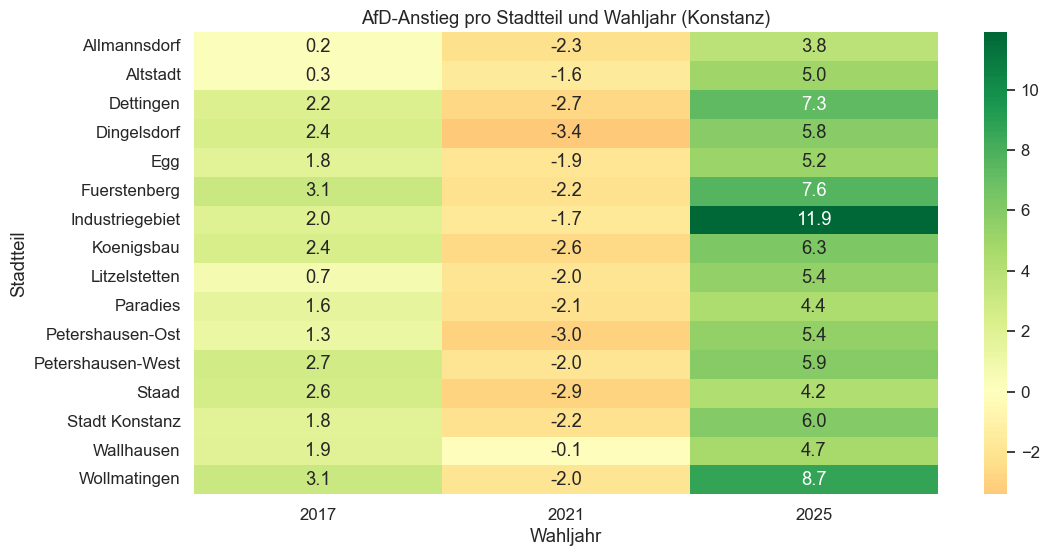

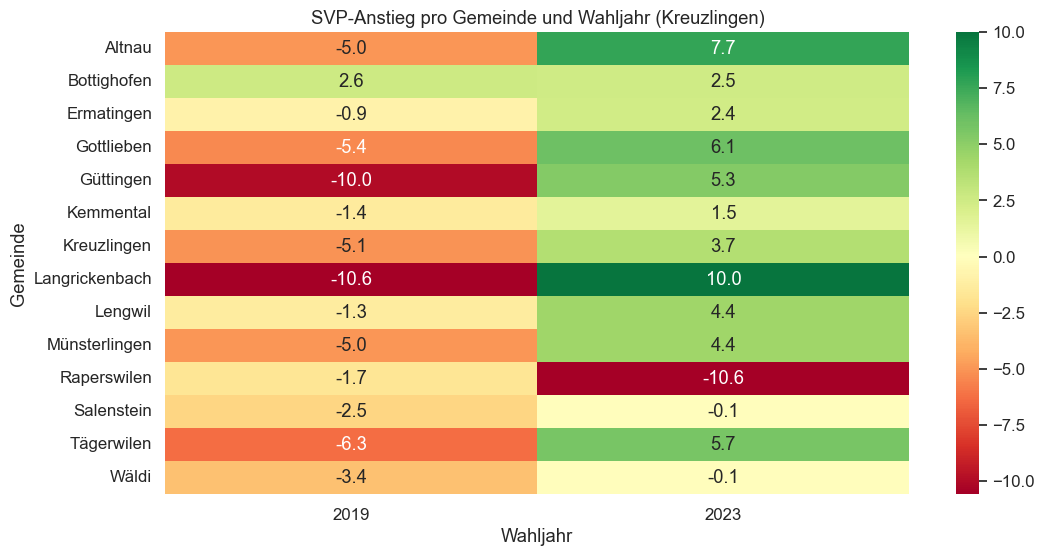

In [104]:
# AfD-Anstieg pro Stadtteil und Wahljahr (Konstanz)
df_kn_sorted = df_kn.sort_values(['stadtteil', 'wahljahr'])
afd_anstieg = df_kn_sorted.groupby('stadtteil')['AfD'].diff()
df_kn_sorted['AfD_Anstieg'] = afd_anstieg

# Pivot-Tabelle: Zeilen=Stadtteil, Spalten=Wahljahr, Werte=AfD-Anstieg
afd_anstieg_pivot = df_kn_sorted.pivot_table(index='stadtteil', columns='wahljahr', values='AfD_Anstieg')

plt.figure(figsize=(12, 6))
sns.heatmap(afd_anstieg_pivot, annot=True, fmt=".1f", cmap="RdYlGn", center=0)
plt.title("AfD-Anstieg pro Stadtteil und Wahljahr (Konstanz)")
plt.ylabel("Stadtteil")
plt.xlabel("Wahljahr")
plt.show()

# SVP-Anstieg pro Gemeinde und Wahljahr (Kreuzlingen)
if all(col in df_kr.columns for col in ['GEMEINDE_NAME', 'WAHLJAHR', 'SVP']):
    df_kr_sorted = df_kr.sort_values(['GEMEINDE_NAME', 'WAHLJAHR'])
    svp_anstieg = df_kr_sorted.groupby('GEMEINDE_NAME')['SVP'].diff()
    df_kr_sorted['SVP_Anstieg'] = svp_anstieg

    # Pivot-Tabelle: Zeilen=Gemeinde, Spalten=Wahljahr, Werte=SVP-Anstieg
    svp_anstieg_pivot = df_kr_sorted.pivot_table(index='GEMEINDE_NAME', columns='WAHLJAHR', values='SVP_Anstieg')

    plt.figure(figsize=(12, 6))
    sns.heatmap(svp_anstieg_pivot, annot=True, fmt=".1f", cmap="RdYlGn", center=0)
    plt.title("SVP-Anstieg pro Gemeinde und Wahljahr (Kreuzlingen)")
    plt.ylabel("Gemeinde")
    plt.xlabel("Wahljahr")
    plt.show()
else:
    print("Spalten für Kreuzlingen nicht vollständig vorhanden.")

## 8. Vergleich Konstanz vs. Kreuzlingen: Demographie und Wahlverhalten

Vergleiche die demographischen Strukturen und das Wahlverhalten (insbesondere Rechtswahl) zwischen Konstanz und Kreuzlingen. Stelle die wichtigsten Unterschiede und Gemeinsamkeiten grafisch und tabellarisch dar.

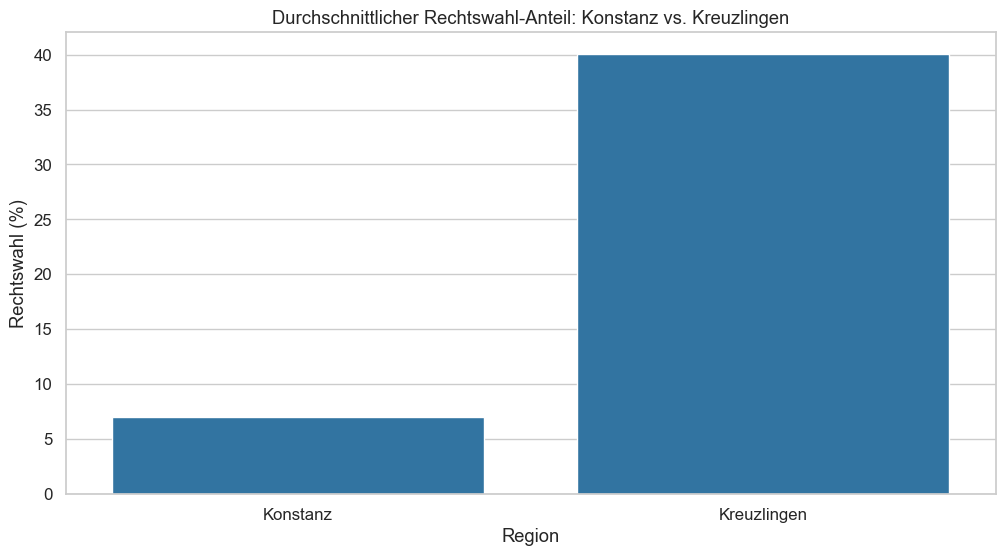

In [105]:
# Vergleichstabelle: AfD vs. SVP, Frauenanteil, Durchschnittsalter
vergleich = pd.DataFrame({
    "Region": ["Konstanz", "Kreuzlingen"],
    "Rechtswahl (%)": [
        df_kn['AfD'].mean() if 'AfD' in df_kn.columns else np.nan,
        df_kr['SVP'].mean() if 'SVP' in df_kr.columns else np.nan
    ],
    "Frauen-Anteil (%)": [
        100 * df_kn['einw_hw_frauen'].sum() / df_kn['einw_hw_gesamt'].sum() if 'einw_hw_frauen' in df_kn.columns else np.nan,
        100 * (df_kr['Weiblich_Schweiz'].sum() + df_kr['Weiblich_Ausland'].sum()) /
        (df_kr['Weiblich_Schweiz'].sum() + df_kr['Weiblich_Ausland'].sum() +
         df_kr['Männlich_Schweiz'].sum() + df_kr['Männlich_Ausland'].sum())
        if all(col in df_kr.columns for col in ['Weiblich_Schweiz', 'Weiblich_Ausland', 'Männlich_Schweiz', 'Männlich_Ausland']) else np.nan
    ]
})

# Visualisierung
sns.barplot(data=vergleich, x="Region", y="Rechtswahl (%)")
plt.title("Durchschnittlicher Rechtswahl-Anteil: Konstanz vs. Kreuzlingen")
plt.show()

/var/folders/xb/3cn73kh15fx078zh0ryb_lrc0000gn/T/ipykernel_9333/183066880.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=vergleich, x="Region", y="Rechtswahl (%)", ax=axes[0], palette="Reds")
/var/folders/xb/3cn73kh15fx078zh0ryb_lrc0000gn/T/ipykernel_9333/183066880.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=vergleich, x="Region", y="Frauen-Anteil (%)", ax=axes[1], palette="Blues")


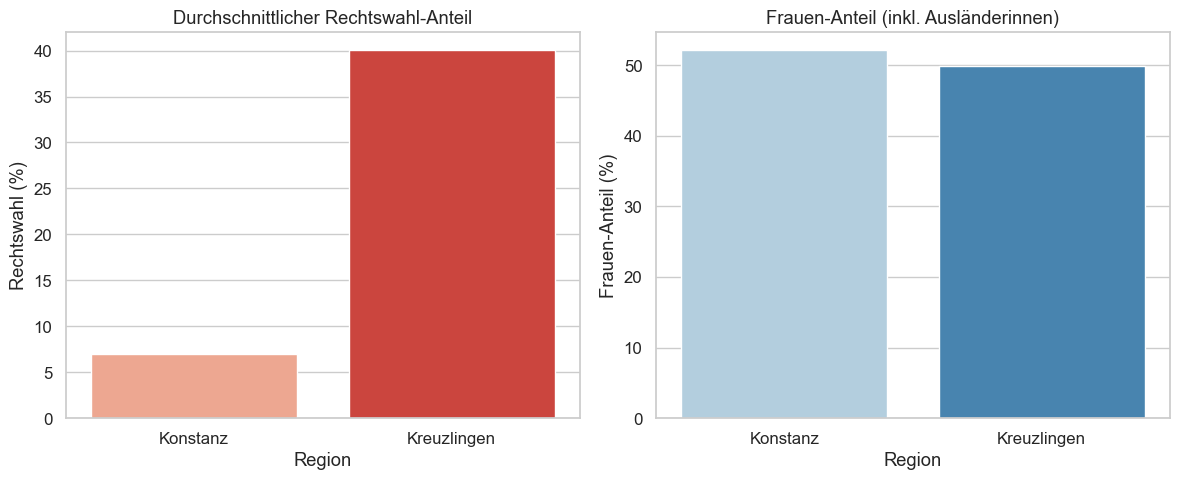

In [106]:
# Visualisierung: Rechtswahl und Frauenanteil nebeneinander
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(data=vergleich, x="Region", y="Rechtswahl (%)", ax=axes[0], palette="Reds")
axes[0].set_title("Durchschnittlicher Rechtswahl-Anteil")
axes[0].set_ylabel("Rechtswahl (%)")

sns.barplot(data=vergleich, x="Region", y="Frauen-Anteil (%)", ax=axes[1], palette="Blues")
axes[1].set_title("Frauen-Anteil (inkl. Ausländerinnen)")
axes[1].set_ylabel("Frauen-Anteil (%)")

plt.tight_layout()
plt.show()

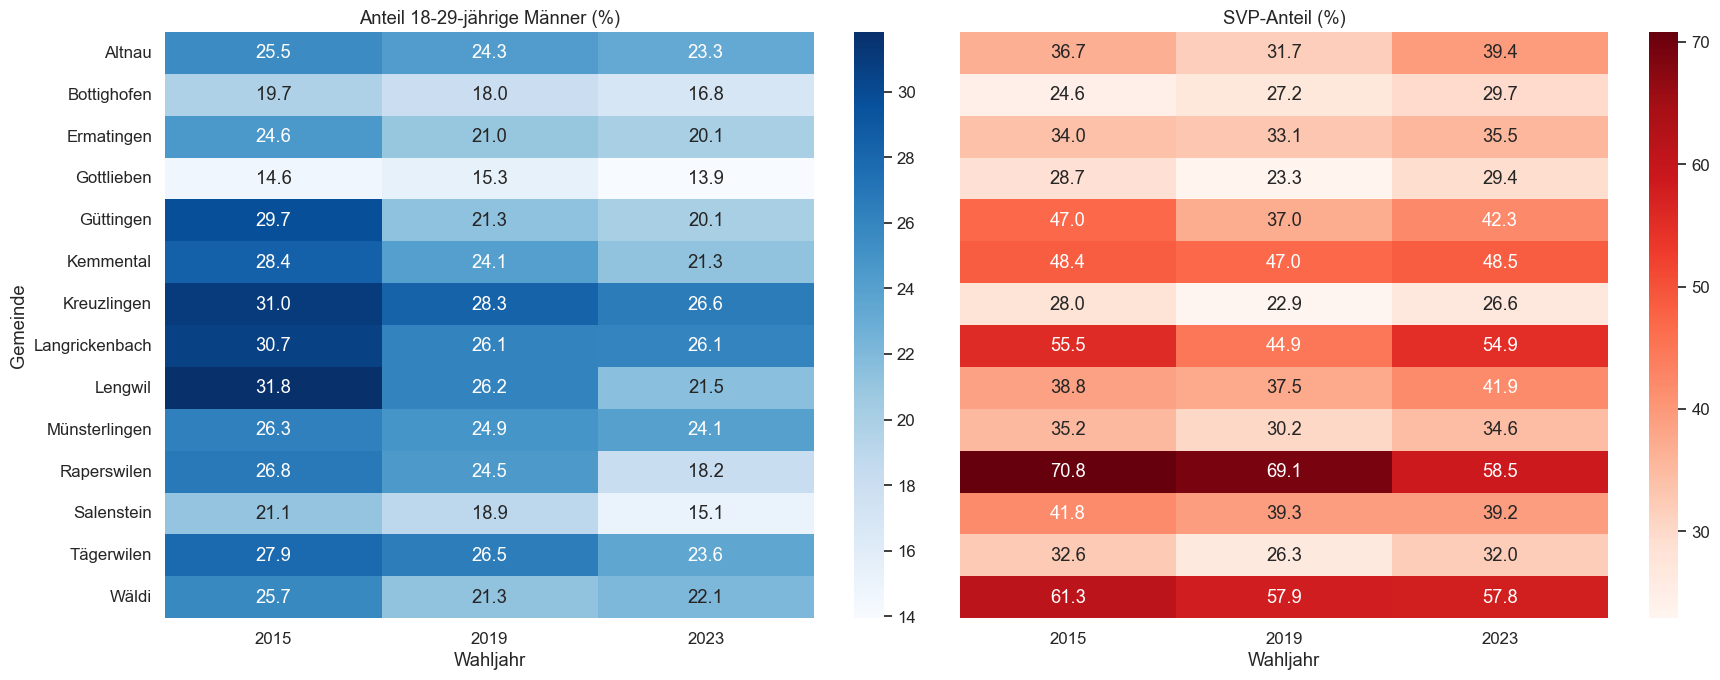

/var/folders/xb/3cn73kh15fx078zh0ryb_lrc0000gn/T/ipykernel_9333/1727904782.py:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


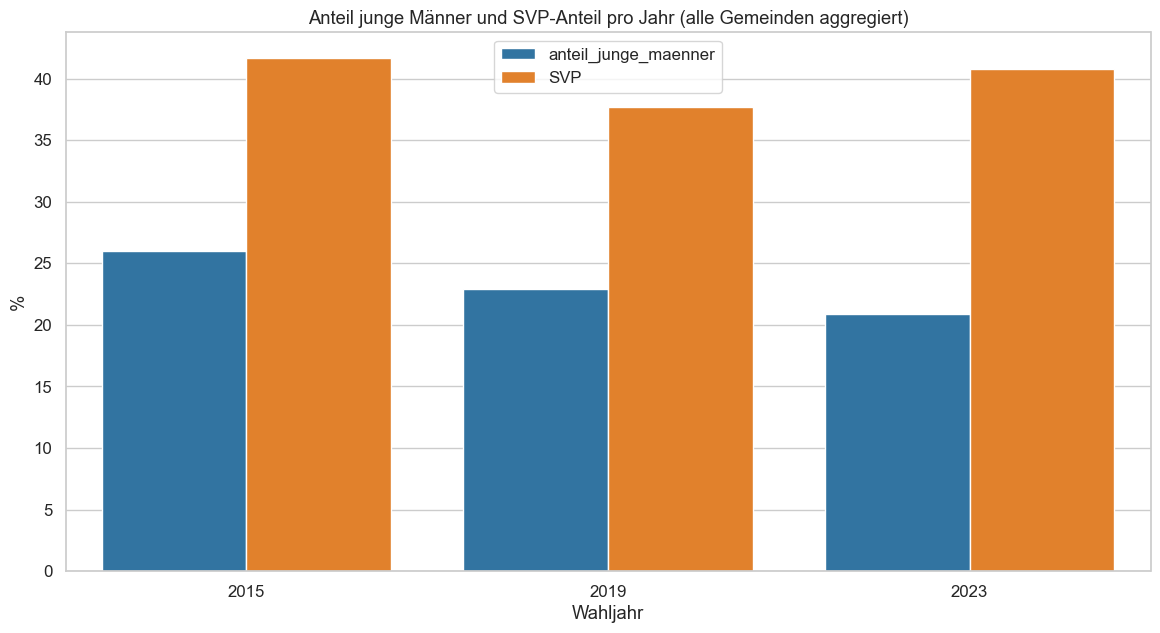

In [107]:
# Anteil junger Männer (18-29) für Kreuzlingen berechnen und visualisieren
if all(col in df_kr.columns for col in ['18-29', 'Männlich_Ausland', 'Männlich_Schweiz', 'GEMEINDE_NAME', 'WAHLJAHR', 'SVP']):
    df_kr['maenner_gesamt'] = df_kr['Männlich_Ausland'] + df_kr['Männlich_Schweiz']
    df_kr['anteil_junge_maenner'] = df_kr['18-29'] / df_kr['maenner_gesamt'] * 100

    # Pivot-Tabellen für Heatmaps
    pivot_junge_maenner_kr = df_kr.pivot_table(index='GEMEINDE_NAME', columns='WAHLJAHR', values='anteil_junge_maenner')
    pivot_svp = df_kr.pivot_table(index='GEMEINDE_NAME', columns='WAHLJAHR', values='SVP')

    # Kombinierte Heatmaps
    fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
    sns.heatmap(pivot_junge_maenner_kr, annot=True, fmt=".1f", cmap="Blues", ax=axes[0])
    axes[0].set_title("Anteil 18-29-jährige Männer (%)")
    axes[0].set_ylabel("Gemeinde")
    axes[0].set_xlabel("Wahljahr")
    sns.heatmap(pivot_svp, annot=True, fmt=".1f", cmap="Reds", ax=axes[1])
    axes[1].set_title("SVP-Anteil (%)")
    axes[1].set_xlabel("Wahljahr")
    axes[1].set_ylabel("")
    plt.tight_layout()
    plt.show()

    # Gruppiertes Balkendiagramm (aggregiert über alle Gemeinden)
    df_bar_kr = df_kr[['GEMEINDE_NAME', 'WAHLJAHR', 'anteil_junge_maenner', 'SVP']].dropna()
    df_bar_kr = pd.melt(df_bar_kr, id_vars=['GEMEINDE_NAME', 'WAHLJAHR'], value_vars=['anteil_junge_maenner', 'SVP'],
                        var_name='Kategorie', value_name='Prozent')
    plt.figure(figsize=(14, 7))
    sns.barplot(
        data=df_bar_kr,
        x='WAHLJAHR',
        y='Prozent',
        hue='Kategorie',
        ci=None
    )
    plt.title("Anteil junge Männer und SVP-Anteil pro Jahr (alle Gemeinden aggregiert)")
    plt.ylabel("%")
    plt.xlabel("Wahljahr")
    plt.legend(title="")
    plt.show()
else:
    print("Benötigte Spalten für Kreuzlingen nicht verfügbar.")

/Users/tessabartels/Desktop/Coding/Datenjournalismus/venv/lib/python3.10/site-packages/pyogrio/raw.py:198: RuntimeWarning: /Users/tessabartels/Desktop/Coding/Datenjournalismus/data/Konstanz/Kleinräumige_Gliederung_-5522761317040177735/Stadtteilfläche.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


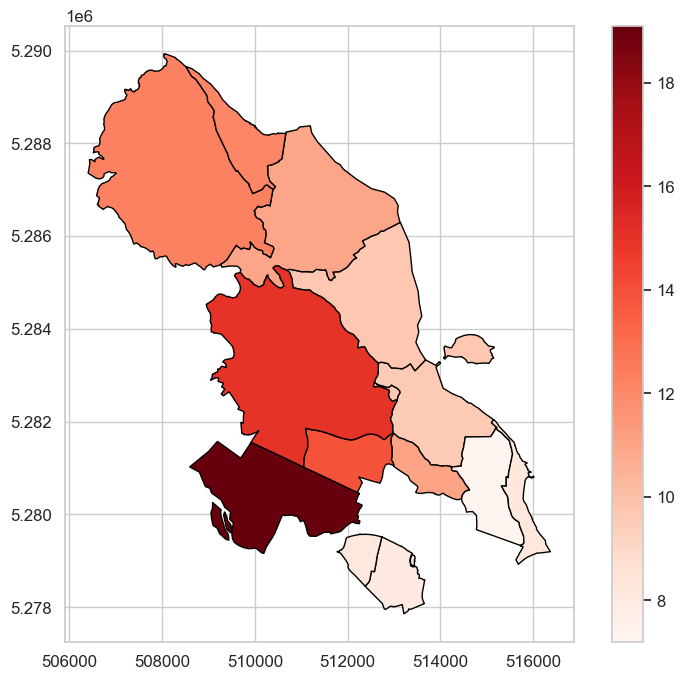

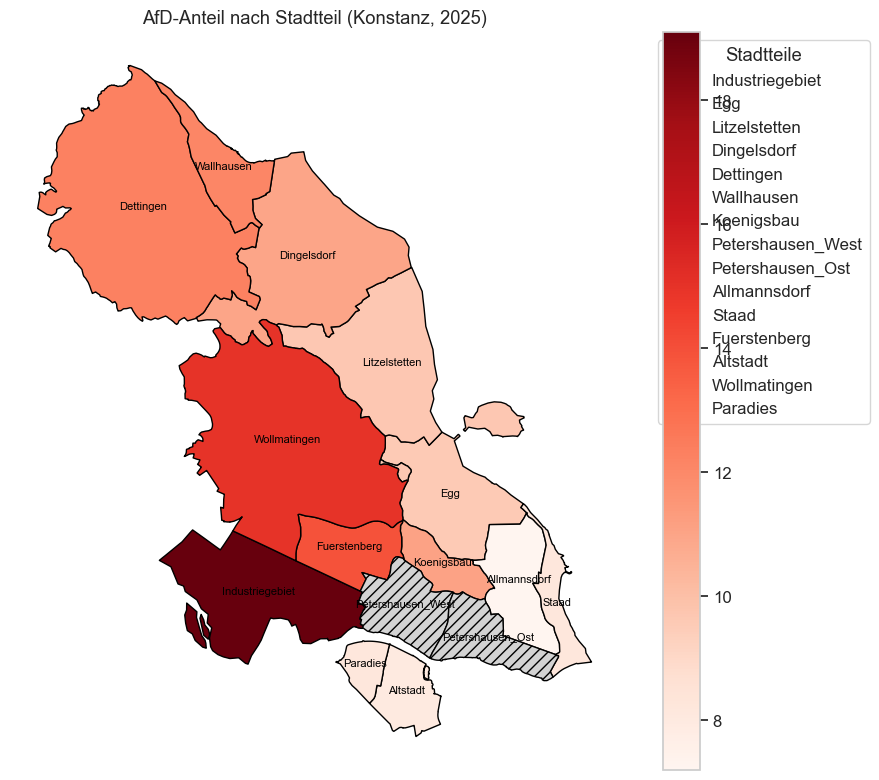

In [108]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Shapefile-Pfad für Konstanz
shp_path_kn = "/Users/tessabartels/Desktop/Coding/Datenjournalismus/data/Konstanz/Kleinräumige_Gliederung_-5522761317040177735/Stadtteilfläche.shp"

# Lade Shapefile
gdf_kn = gpd.read_file(shp_path_kn)

# Annahme: Die Spalte mit dem Stadtteilnamen heißt 'STT_NAME'
jahr_kn = df_kn['wahljahr'].max()
df_kn_map = df_kn[df_kn['wahljahr'] == jahr_kn][['stadtteil', 'AfD']]
gdf_kn['stadtteil'] = gdf_kn['STT_NAME'].str.strip()
gdf_kn = gdf_kn.merge(df_kn_map, on='stadtteil', how='left')



# Plot
fig, ax = plt.subplots(figsize=(10, 8))
gdf_kn.plot(column='AfD', cmap='Reds', legend=True, edgecolor='black', ax=ax)

# ...existing code...
fig, ax = plt.subplots(figsize=(10, 8))
gdf_kn.plot(
    column='AfD',
    cmap='Reds',
    legend=True,
    edgecolor='black',
    ax=ax,
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "black",
        "hatch": "///",
        "label": "Keine Daten"
    }
)
# ...existing code...

# Stadtteilnamen als Legende
patches = [Patch(facecolor='white', edgecolor='black', label=name) for name in gdf_kn['stadtteil']]
plt.legend(handles=patches, title="Stadtteile", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(f"AfD-Anteil nach Stadtteil (Konstanz, {jahr_kn})")
plt.axis('off')
plt.tight_layout()
for idx, row in gdf_kn.iterrows():
    ax.annotate(
        text=row['stadtteil'],
        xy=(row.geometry.centroid.x, row.geometry.centroid.y),
        ha='center', fontsize=8, color='black'
    )
plt.show()

/Users/tessabartels/Desktop/Coding/Datenjournalismus/venv/lib/python3.10/site-packages/pyogrio/raw.py:198: RuntimeWarning: /Users/tessabartels/Desktop/Coding/Datenjournalismus/data/Konstanz/Kleinräumige_Gliederung_-5522761317040177735/Stadtteilfläche.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


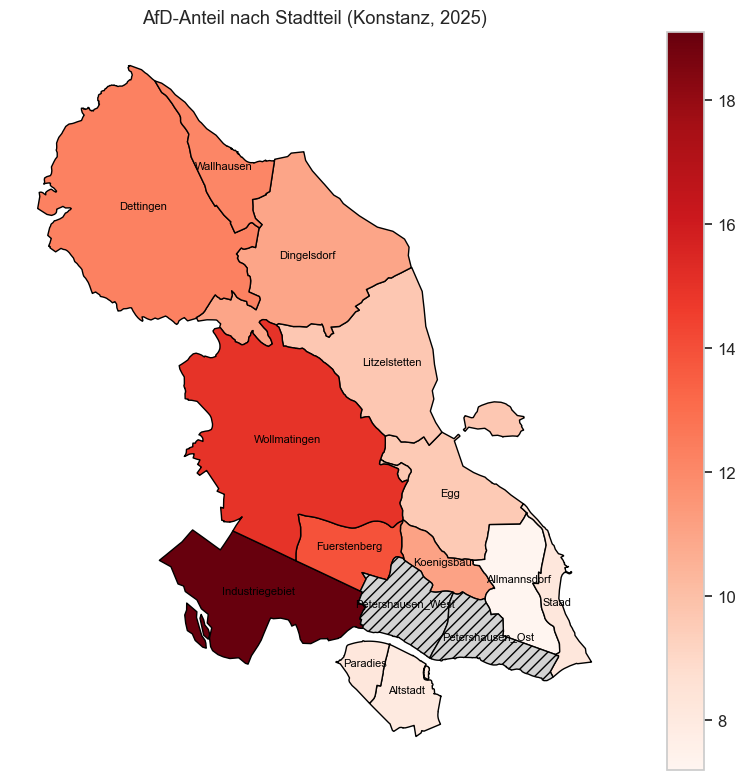

In [109]:
import geopandas as gpd

# Shapefile-Pfad für Konstanz Stadtteile
shp_path_kn = f"{data_dir}/Konstanz/Kleinräumige_Gliederung_-5522761317040177735/Stadtteilfläche.shp"
if os.path.exists(shp_path_kn):
    gdf_kn = gpd.read_file(shp_path_kn)
    # Annahme: Spalte mit Stadtteilnamen heißt 'STT_NAME'
    gdf_kn['stadtteil'] = gdf_kn['STT_NAME'].str.strip()
    df_kn_map = df_kn[df_kn['wahljahr'] == jahr_kn][['stadtteil', 'AfD']]
    gdf_kn = gdf_kn.merge(df_kn_map, on='stadtteil', how='left')

    fig, ax = plt.subplots(figsize=(10, 8))
    gdf_kn.plot(column='AfD', cmap='Reds', legend=True, edgecolor='black', ax=ax,
                missing_kwds={"color": "lightgrey", "edgecolor": "black", "hatch": "///", "label": "Keine Daten"})
    plt.title(f"AfD-Anteil nach Stadtteil (Konstanz, {jahr_kn})")
    plt.axis('off')
    plt.tight_layout()
    for idx, row in gdf_kn.iterrows():
        ax.annotate(text=row['stadtteil'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                    ha='center', fontsize=8, color='black')
    plt.show()
else:
    print("Shapefile für Konstanz-Stadtteile nicht gefunden. Kartenvisualisierung übersprungen.")

/Users/tessabartels/Desktop/Coding/Datenjournalismus/venv/lib/python3.10/site-packages/pyogrio/raw.py:198: RuntimeWarning: /Users/tessabartels/Desktop/Coding/Datenjournalismus/data/Konstanz/Kleinräumige_Gliederung_-5522761317040177735/Stadtteilfläche.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


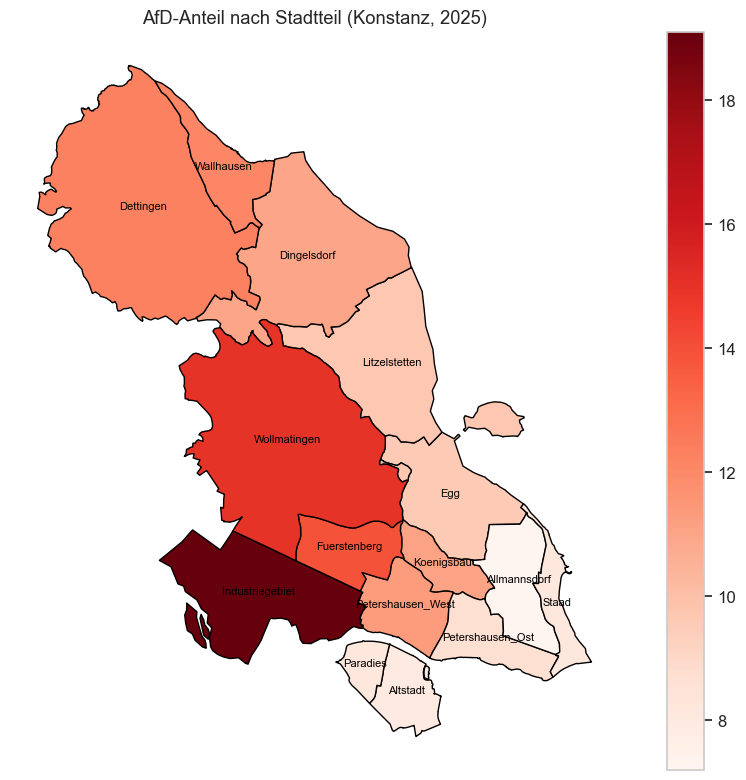

Text(0.5, 1.0, 'SVP-Anteil nach Gemeinde (Kreuzlingen, 2023)')

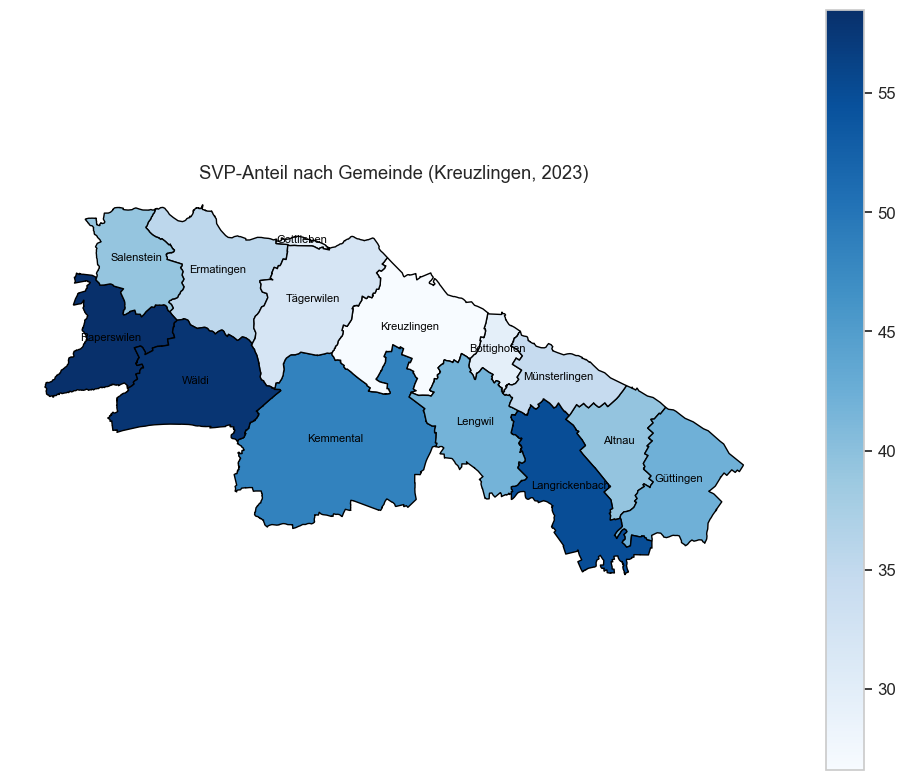

In [110]:
import geopandas as gpd
import matplotlib.pyplot as plt

# --- Konstanz Stadtteile (Shapefile) ---
import geopandas as gpd

# Shapefile-Pfad für Konstanz Stadtteile
shp_path_kn = f"{data_dir}/Konstanz/Kleinräumige_Gliederung_-5522761317040177735/Stadtteilfläche.shp"
if os.path.exists(shp_path_kn):
    gdf_kn = gpd.read_file(shp_path_kn)
    # Annahme: Spalte mit Stadtteilnamen heißt 'STT_NAME'
    gdf_kn['stadtteil'] = gdf_kn['STT_NAME'].str.strip()

    # Korrigiere die Schreibweise im DataFrame für den Join
    df_kn['stadtteil'] = df_kn['stadtteil'].str.replace('-', '_', regex=False).str.strip()

    jahr_kn = df_kn['wahljahr'].max()
    df_kn_map = df_kn[df_kn['wahljahr'] == jahr_kn][['stadtteil', 'AfD']]
    gdf_kn = gdf_kn.merge(df_kn_map, on='stadtteil', how='left')

    fig, ax = plt.subplots(figsize=(10, 8))
    gdf_kn.plot(column='AfD', cmap='Reds', legend=True, edgecolor='black', ax=ax,
                missing_kwds={"color": "lightgrey", "edgecolor": "black", "hatch": "///", "label": "Keine Daten"})
    plt.title(f"AfD-Anteil nach Stadtteil (Konstanz, {jahr_kn})")
    plt.axis('off')
    plt.tight_layout()
    for idx, row in gdf_kn.iterrows():
        ax.annotate(text=row['stadtteil'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                    ha='center', fontsize=8, color='black')
    plt.show()
else:
    print("Shapefile für Konstanz-Stadtteile nicht gefunden. Kartenvisualisierung übersprungen.")

# --- Kreuzlingen Gemeinden (GeoJSON) ---
gdf_kr = gpd.read_file("/Users/tessabartels/Desktop/Coding/Datenjournalismus/data/Kreuzlingen:Kanton Thurgau/export-3.geojson")
jahr_kr = df_kr['WAHLJAHR'].max()
df_kr_map = df_kr[df_kr['WAHLJAHR'] == jahr_kr][['GEMEINDE_NAME', 'SVP']]
gdf_kr['GEMEINDE_NAME'] = gdf_kr['name'].str.strip()
gdf_kr = gdf_kr.merge(df_kr_map, on='GEMEINDE_NAME', how='left')

# Karte Kreuzlingen (SVP)
fig, ax = plt.subplots(figsize=(10, 8))
gdf_kr.plot(column='SVP', cmap='Blues', legend=True, edgecolor='black', ax=ax, 
            missing_kwds={"color": "lightgrey", "edgecolor": "black", "hatch": "///", "label": "Keine Daten"})
for idx, row in gdf_kr.iterrows():
        ax.annotate(text=row['GEMEINDE_NAME'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                    ha='center', fontsize=8, color='black')
plt.axis('off')
plt.tight_layout()
plt.title(f"SVP-Anteil nach Gemeinde (Kreuzlingen, {jahr_kr})")

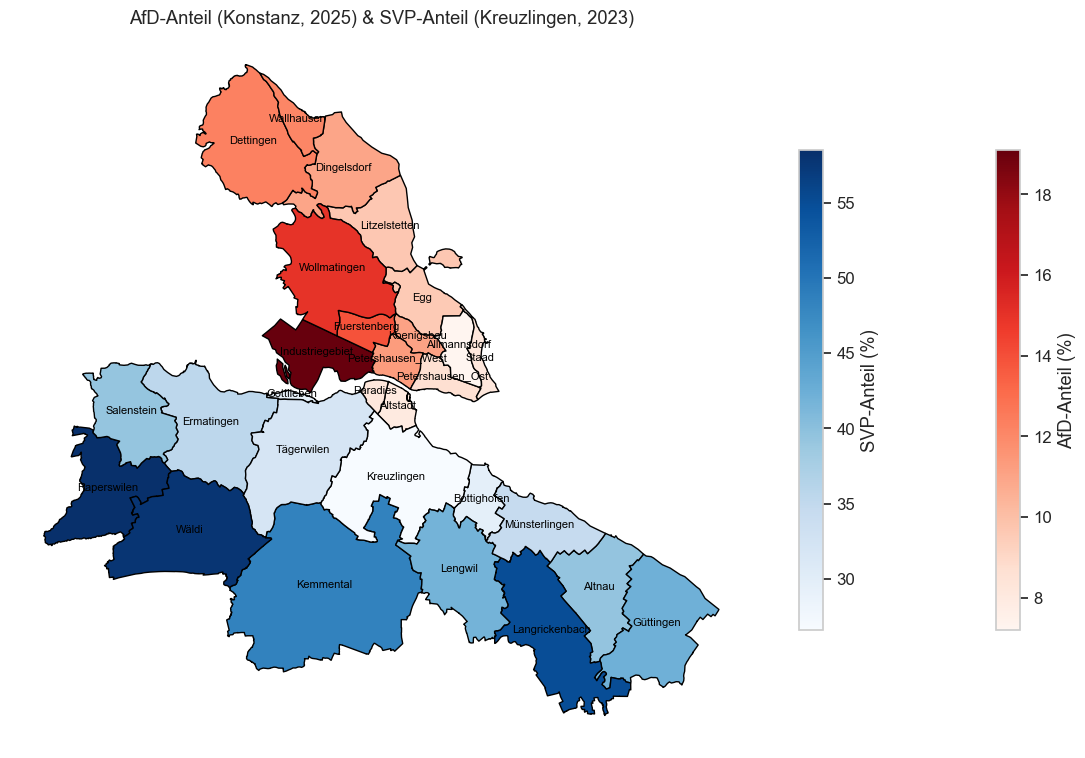

In [111]:
import geopandas as gpd
import matplotlib.pyplot as plt
import os



# --- CRS vereinheitlichen ---
if gdf_kn.crs != gdf_kr.crs:
    gdf_kr = gdf_kr.to_crs(gdf_kn.crs)

# --- Gemeinsame Karte ---
fig, ax = plt.subplots(figsize=(12, 10))

gdf_kn.plot(
    column='AfD',
    cmap='Reds',
    edgecolor='black',
    ax=ax,
    legend=True,
    legend_kwds={'label': "AfD-Anteil (%)", 'shrink': 0.5},
    missing_kwds={"color": "lightgrey", "edgecolor": "black", "hatch": "///", "label": "Keine Daten"}
)

gdf_kr.plot(
    column='SVP',
    cmap='Blues',
    edgecolor='black',
    ax=ax,
    legend=True,
    legend_kwds={'label': "SVP-Anteil (%)", 'shrink': 0.5},
    missing_kwds={"color": "lightgrey", "edgecolor": "black", "hatch": "///", "label": "Keine Daten"}
)

for idx, row in gdf_kr.iterrows():
        ax.annotate(text=row['GEMEINDE_NAME'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                    ha='center', fontsize=8, color='black')
        

for idx, row in gdf_kn.iterrows():
    ax.annotate(text=row['stadtteil'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                ha='center', fontsize=8, color='black')

plt.title(f"AfD-Anteil (Konstanz, {jahr_kn}) & SVP-Anteil (Kreuzlingen, {jahr_kr})")
plt.axis('off')
plt.tight_layout()

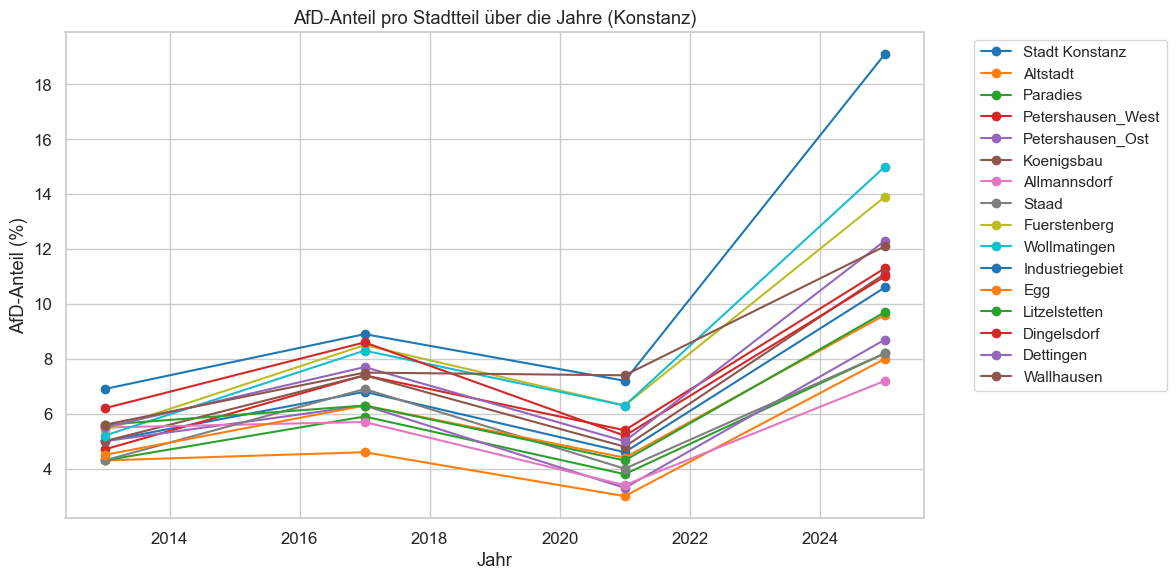

In [112]:
# Entwicklung AfD-Anteil pro Stadtteil über die Jahre (Konstanz)
for stadtteil in df_kn['stadtteil'].unique():
    df_st = df_kn[df_kn['stadtteil'] == stadtteil]
    plt.plot(df_st['wahljahr'], df_st['AfD'], marker='o', label=stadtteil)
plt.xlabel("Jahr")
plt.ylabel("AfD-Anteil (%)")
plt.title("AfD-Anteil pro Stadtteil über die Jahre (Konstanz)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()


## 9. Zeitliche Dynamiken: Veränderungen über die Jahre

Analysiere die Entwicklung von demographischen Merkmalen und Rechtswahl-Anteilen über die Zeit (mehrere Wahljahre). Erstelle Liniendiagramme und Heatmaps für die wichtigsten Trends.

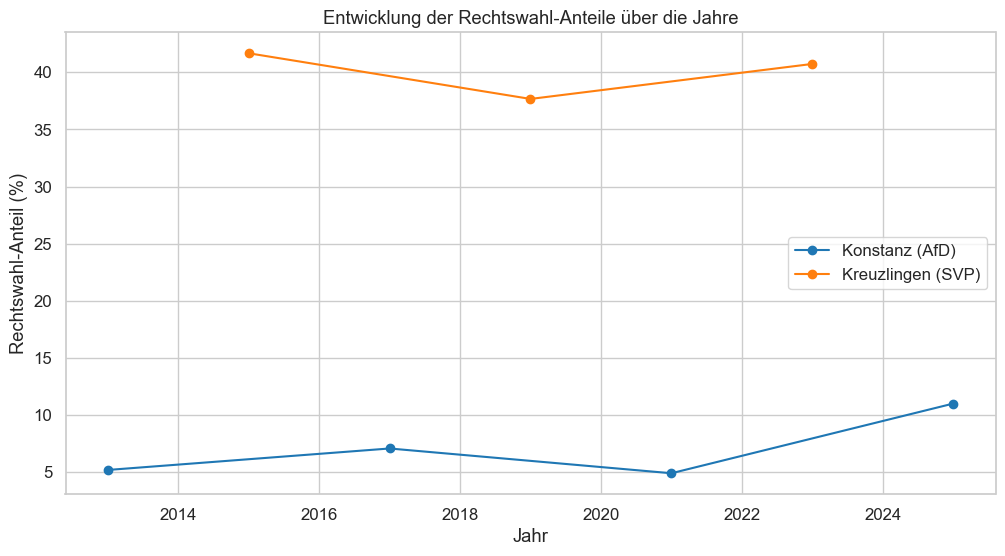

In [113]:
# Zeitreihe: AfD-Anteil in Konstanz und SVP-Anteil in Kreuzlingen
if 'wahljahr' in df_kn.columns and 'AfD' in df_kn.columns:
    trend_kn = df_kn.groupby('wahljahr')['AfD'].mean().reset_index()
    plt.plot(trend_kn['wahljahr'], trend_kn['AfD'], marker='o', label='Konstanz (AfD)')
if 'WAHLJAHR' in df_kr.columns and 'SVP' in df_kr.columns:
    trend_kr = df_kr.groupby('WAHLJAHR')['SVP'].mean().reset_index()
    plt.plot(trend_kr['WAHLJAHR'], trend_kr['SVP'], marker='o', label='Kreuzlingen (SVP)')
plt.xlabel("Jahr")
plt.ylabel("Rechtswahl-Anteil (%)")
plt.title("Entwicklung der Rechtswahl-Anteile über die Jahre")
plt.legend()
plt.show()

## 10. Kanton Thurgau: Datenüberblick und Preprocessing


Kanton Thurgau Parteistärken (gesamt):
                               Unnamed: 0  1971  1975  1979  1983  1987  1991  \
0   Bürgerlich-Demokratische Partei (BDP)     -     -     -     -     -     -   
1                              Die Mitte1  23.4  22.3  24.6  21.6  20.4  16.5   
2  Eidgnössisch-Demokratische Union (EDU)     -     -     -     -     -     -   
3          Evangelische Volkspartei (EVP)     -     -     -   5.3     -   3.2   
4       FDP. Die Liberalen Thurgau  (FDP)  16.9  14.4  16.9  18.3  18.5  16.5   

   1995  1999       2003  2007  2011  2015  2019  2023  
0     -     -          -     -   5.0   3.8   2.3     -  
1    13  15.8  16.450649  15.2  14.4  13.1  12.7  15.3  
2     -   1.9        1.9   2.6   3.5   3.4   2.8   2.8  
3   2.7   2.8        2.7   2.8   2.9   2.3   2.7   2.4  
4  15.3  14.7   11.88747  12.1  11.2  13.0  11.5  10.7  
Bezirksdaten Kanton Thurgau (inkl. SVP-Anteil):
          BEZIRK_NAME  WAHLJAHR   SVP
0        Bezirk Arbon      2015  38.3
1   Bezi

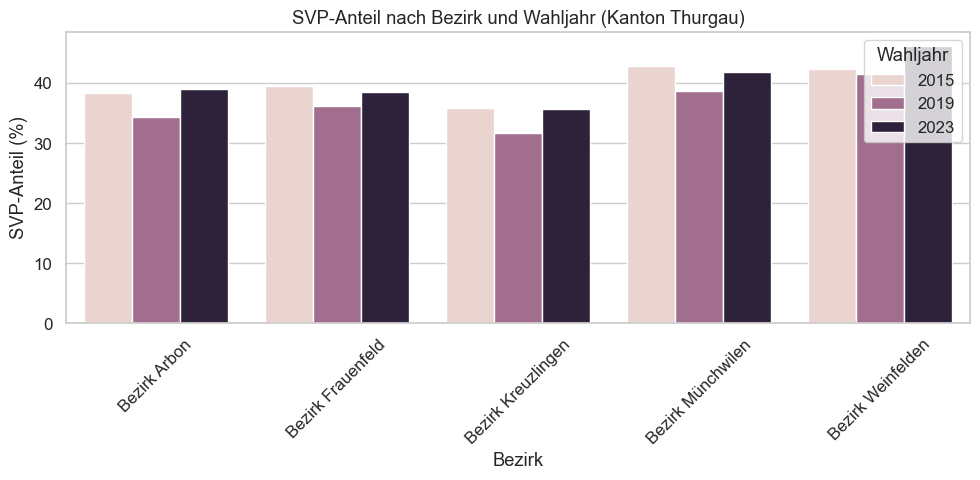

In [114]:
# Lade die aggregierten Daten auf Bezirksebene (inkl. Kanton Thurgau)
df_bezirk_parteistaerke = pd.read_csv(f"{output_dir}/df_bezirk_parteistaerke_kt.csv")

# Optional: Lade die Parteistärken für den gesamten Kanton Thurgau (falls vorhanden)
# Beispiel-Datei: Parteistaerken_an_Nationalratswahlen_1971_2023.xlsx
file_kt_gesamt = f"{data_dir}/Kreuzlingen:Kanton Thurgau/Parteistaerken_an_Nationalratswahlen_1971_2023.xlsx"
if os.path.exists(file_kt_gesamt):
    df_kt_gesamt = pd.read_excel(file_kt_gesamt, header=2)
    print("Kanton Thurgau Parteistärken (gesamt):")
    print(df_kt_gesamt.head())

# Überblick: Bezirke und Rechtswahl (SVP) im Kanton Thurgau
print("Bezirksdaten Kanton Thurgau (inkl. SVP-Anteil):")
print(df_bezirk_parteistaerke[["BEZIRK_NAME", "WAHLJAHR", "SVP"]].dropna().head())

# Beispiel-Visualisierung: SVP-Anteil nach Bezirk und Jahr
plt.figure(figsize=(10, 5))
sns.barplot(
    data=df_bezirk_parteistaerke,
    x="BEZIRK_NAME",
    y="SVP",
    hue="WAHLJAHR"
)
plt.title("SVP-Anteil nach Bezirk und Wahljahr (Kanton Thurgau)")
plt.ylabel("SVP-Anteil (%)")
plt.xlabel("Bezirk")
plt.xticks(rotation=45)
plt.legend(title="Wahljahr")
plt.tight_layout()
plt.show()

# 11. Landkreis Konstanz

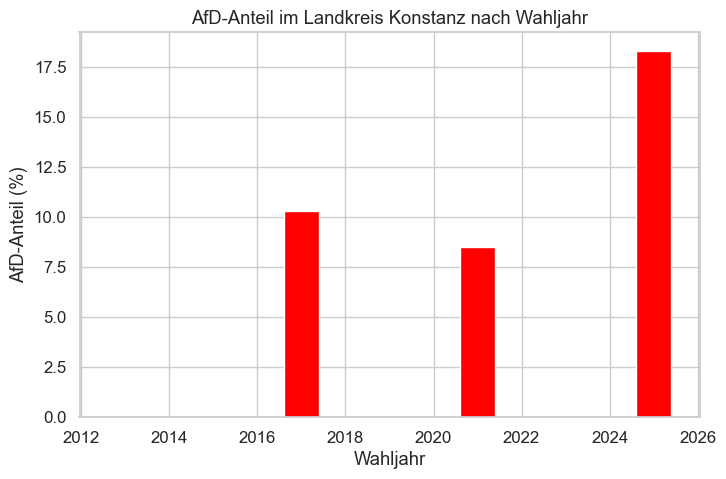

   wahljahr   AfD  Durchschnittsalter  Anteil_Deutsche (%)  \
0      2013   0.0                43.1            89.318448   
1      2017  10.3                42.9            87.254992   
2      2021   8.5                43.4            86.232060   
3      2025  18.3                43.3            85.214515   

   Anteil_Ausländer (%)  
0             10.681552  
1             12.745008  
2             13.767940  
3             14.785485  


In [115]:
import pandas as pd
import matplotlib.pyplot as plt

# Lade die Daten
df_lk = pd.read_csv("/Users/tessabartels/Desktop/Coding/Datenjournalismus/data/output_preprocessing/df_lk_kn_gesamt_wahl.csv")

# AfD-Anteil nach Wahljahr (Balkendiagramm)
plt.figure(figsize=(8,5))
plt.bar(df_lk['wahljahr'], df_lk['AfD'], color='red')
plt.xlabel("Wahljahr")
plt.ylabel("AfD-Anteil (%)")
plt.title("AfD-Anteil im Landkreis Konstanz nach Wahljahr")
plt.show()

# Durchschnittsalter berechnen (gewichtetes Mittel der Altersgruppen)
altersgruppen = [
    ('0-17', 9),
    ('18-29', 24),
    ('30-39', 35),
    ('40-49', 45),
    ('50-59', 55),
    ('60-69', 65),
    ('70-79', 75),
    ('80+', 85)
]
def berechne_durchschnittsalter(row):
    gesamt = 0
    einwohner = 0
    for spalte, mittelwert in altersgruppen:
        n = row[spalte] if not pd.isna(row[spalte]) else 0
        gesamt += n * mittelwert
        einwohner += n
    return round(gesamt / einwohner, 1) if einwohner > 0 else None

df_lk['Durchschnittsalter'] = df_lk.apply(berechne_durchschnittsalter, axis=1)

# Anteil Deutsche und Ausländer pro Wahljahr
df_lk['Anteil_Deutsche (%)'] = 100 * df_lk['insgesamt_dt'] / df_lk['gesamtbevölkerung']
df_lk['Anteil_Ausländer (%)'] = 100 * df_lk['zusammen_aus'] / df_lk['gesamtbevölkerung']

# Ausgabe als Tabelle
print(df_lk[['wahljahr', 'AfD', 'Durchschnittsalter', 'Anteil_Deutsche (%)', 'Anteil_Ausländer (%)']])

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Lade die Daten
df_lk = pd.read_csv("/Users/tessabartels/Desktop/Coding/Datenjournalismus/data/output_preprocessing/df_lk_kn_gesamt_wahl.csv")

# Durchschnittsalter berechnen (gewichtetes Mittel der Altersgruppen)
altersgruppen = [
    ('0-17', 9),
    ('18-29', 24),
    ('30-39', 35),
    ('40-49', 45),
    ('50-59', 55),
    ('60-69', 65),
    ('70-79', 75),
    ('80+', 85)
]
def berechne_durchschnittsalter(row):
    gesamt = 0
    einwohner = 0
    for spalte, mittelwert in altersgruppen:
        n = row[spalte] if not pd.isna(row[spalte]) else 0
        gesamt += n * mittelwert
        einwohner += n
    return round(gesamt / einwohner, 1) if einwohner > 0 else None

df_lk['Durchschnittsalter'] = df_lk.apply(berechne_durchschnittsalter, axis=1)
df_lk['Anteil_Deutsche (%)'] = 100 * df_lk['insgesamt_dt'] / df_lk['gesamtbevölkerung']
df_lk['Anteil_Ausländer (%)'] = 100 * df_lk['zusammen_aus'] / df_lk['gesamtbevölkerung']





# Übersichtstabelle
print(df_lk[['wahljahr', 'AfD', 'Durchschnittsalter', 'Anteil_Deutsche (%)', 'Anteil_Ausländer (%)']])

   wahljahr   AfD  Durchschnittsalter  Anteil_Deutsche (%)  \
0      2013   0.0                43.1            89.318448   
1      2017  10.3                42.9            87.254992   
2      2021   8.5                43.4            86.232060   
3      2025  18.3                43.3            85.214515   

   Anteil_Ausländer (%)  
0             10.681552  
1             12.745008  
2             13.767940  
3             14.785485  


/var/folders/xb/3cn73kh15fx078zh0ryb_lrc0000gn/T/ipykernel_9333/3338760117.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


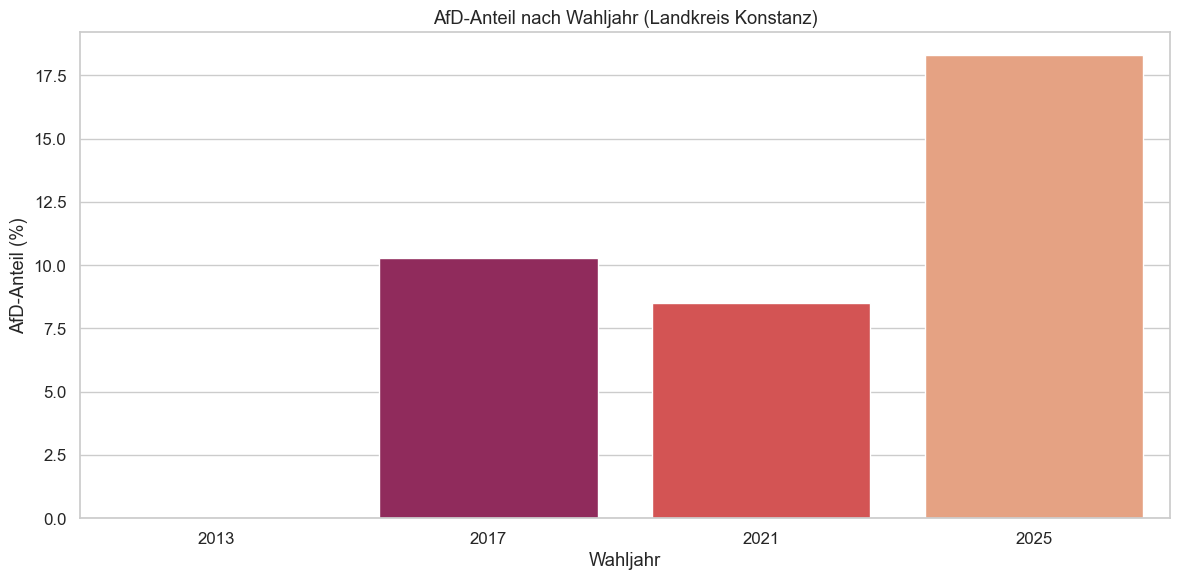

In [124]:
# Farbpalette wie bei Thurgau (3 Jahre: 2015, 2019, 2023 → 2013, 2017, 2021, 2025)
jahre = sorted(df_lk['wahljahr'].unique())
farben = sns.color_palette("rocket", n_colors=len(jahre))  # gleiche Anzahl Farben wie Jahre

# Mapping Jahr → Farbe
jahr2farbe = {jahr: farbe for jahr, farbe in zip(jahre, farben)}

plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_lk,
    x="wahljahr",
    y="AfD",
    palette=[jahr2farbe[j] for j in df_lk['wahljahr']]
)
plt.title("AfD-Anteil nach Wahljahr (Landkreis Konstanz)")
plt.ylabel("AfD-Anteil (%)")
plt.xlabel("Wahljahr")
plt.tight_layout()
plt.show()

In [128]:
df_lk

wahljahr  demo_jahr  insgesamt_dt  zusammen_aus  gesamtbevölkerung   0-17  \
0      2013       2014        275785         32981             308766  49224   
1      2017       2017        284015         41485             325500  52066   
2      2021       2021        288097         45998             334095  54877   
3      2025       2023        291397         50560             341957  56876   

   18-29  30-39  40-49  50-59  ...   CDU   SPD  GRÜNE   FDP   AfD  DIE LINKE  \
0  51786  37717  45897  45904  ...  43.6  20.2   12.7   7.4   0.0        5.0   
1  56691  41533  42923  50150  ...  33.2  15.6   16.0  13.2  10.3        7.2   
2  54205  44628  40137  51085  ...  23.2  20.9   21.0  15.0   8.5        3.7   
3  54201  46933  41996  48912  ...  30.1  13.3   16.8   5.8  18.3        7.4   

   Sonstige  Durchschnittsalter  Anteil_Deutsche (%)  Anteil_Ausländer (%)  
0      11.2                43.1            89.318448             10.681552  
1       4.6                42.9            87.254992             12.745008  
2       7.7                43.4            86.232060             13.767940  
3       8.2                43.3            85.214515             14.785485  

[4 rows x 23 columns]

In [131]:
df_lk_kn_gesamt = pd.read_csv('/Users/tessabartels/Desktop/Coding/Datenjournalismus/data/output_preprocessing/df_DE_wahlen.csv')

In [ ]:
df_lk_kn_gesamt

Jahr   CDU   SPD  GRÜNE   FDP   AfD  DIE LINKE  Sonstige
0  2013  43.6  20.2   12.7   7.4   0.0        5.0      11.2
1  2017  33.2  15.6   16.0  13.2  10.3        7.2       4.6
2  2021  23.2  20.9   21.0  15.0   8.5        3.7       7.7
3  2025  30.1  13.3   16.8   5.8  18.3        7.4       8.2

/var/folders/xb/3cn73kh15fx078zh0ryb_lrc0000gn/T/ipykernel_9333/3963002625.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


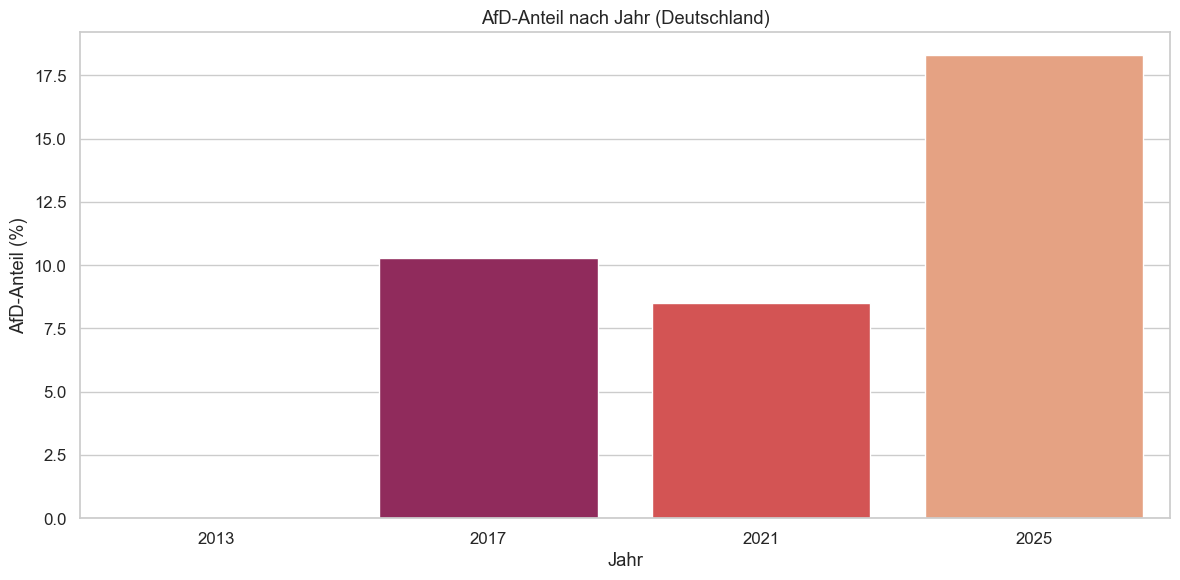

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Farbpalette wie bei Thurgau/Konstanz für die Jahre
jahre = df_lk_kn_gesamt['Jahr'].tolist()
farben = sns.color_palette("rocket", n_colors=len(jahre))
jahr2farbe = {jahr: farbe for jahr, farbe in zip(jahre, farben)}

plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_lk_kn_gesamt,
    x="Jahr",
    y="AfD",
    palette=[jahr2farbe[j] for j in df_lk_kn_gesamt['Jahr']]
)
plt.title("AfD-Anteil nach Jahr (Deutschland)")
plt.ylabel("AfD-Anteil (%)")
plt.xlabel("Jahr")
plt.tight_layout()
plt.show()

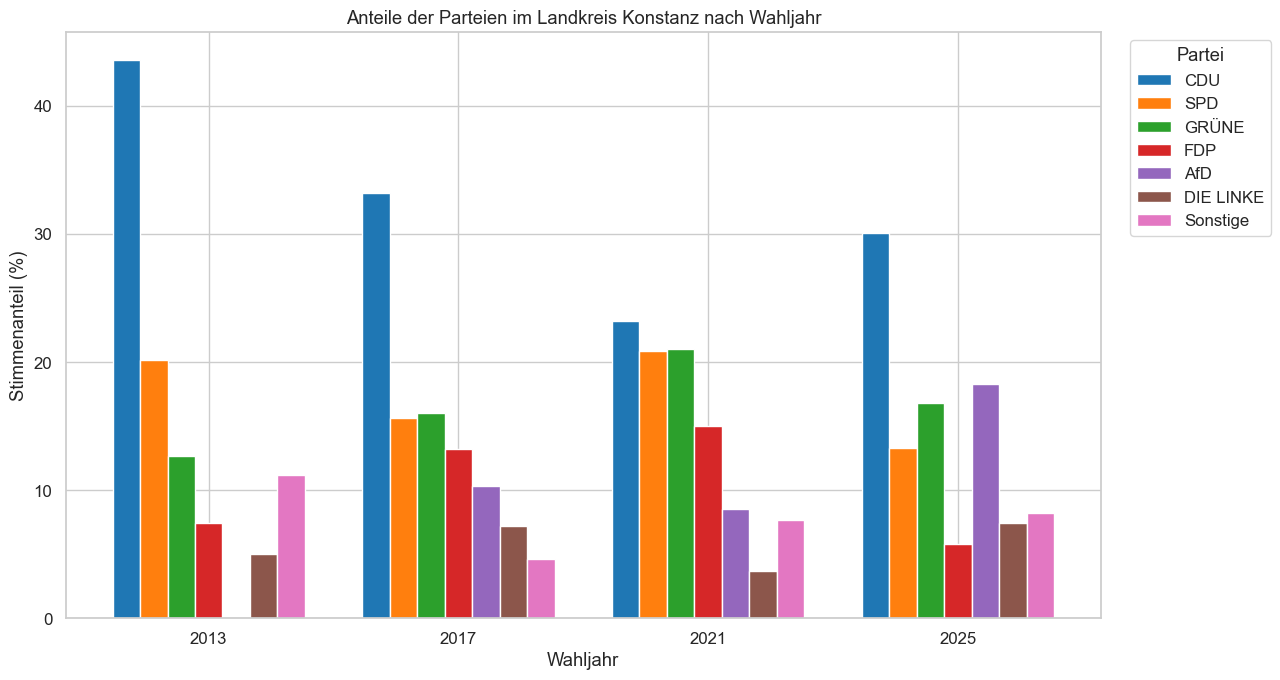

In [130]:
import matplotlib.pyplot as plt
import numpy as np

parteien = ['CDU', 'SPD', 'GRÜNE', 'FDP', 'AfD', 'DIE LINKE', 'Sonstige']
farben = plt.get_cmap("tab10").colors

x = np.arange(len(df_lk['wahljahr']))
breite = 0.11  # Balkenbreite

plt.figure(figsize=(13, 7))
for i, partei in enumerate(parteien):
    plt.bar(x + i*breite - (breite*3), df_lk[partei], width=breite, label=partei, color=farben[i % len(farben)])

plt.xticks(x, df_lk['wahljahr'])
plt.xlabel("Wahljahr")
plt.ylabel("Stimmenanteil (%)")
plt.title("Anteile der Parteien im Landkreis Konstanz nach Wahljahr")
plt.legend(title="Partei", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()